<a href="https://colab.research.google.com/github/zhaoyu-zhang/PDGM-Geometric_Asian/blob/master/PDGM_geometric_asian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functional Feynman-Kac Formula [Dupire (2009)]

Let $x$ be a process given by the SDE 
$$dx_s = \mu(X_s) ds + \sigma(X_s) dw_x.$$

Consider functionals $g :\Lambda_T \longrightarrow R$, $\lambda: \Lambda \longrightarrow R$ and $k:\Lambda \longrightarrow R$ and define the functional $f$ as
$$f(Y_t) = E\left[\left.e^{-\int_t^T \lambda(X_u) du} g(X_T) + \int_t^T e^{-\int_t^s \lambda(X_u) du} k(X_s) ds \ \right| \ Y_t \right],$$
for any path $Y_t \in \Lambda$, $t \in [0,T]$ Thus, if $f \in C^{1,2}$ and $k$, $\lambda$, $\mu$ and $\sigma$ are $\Lambda$-continuous, then $f$ satisfies the Path-dependent Partial Differential Equation (PPDE):
$$
\Delta_t f(Y_t) + \mu(Y_t) \Delta_x f(Y_t)  + \frac{1}{2} \sigma^2(Y_t) \Delta_{xx} f(Y_t) - \lambda(Y_t)f(Y_t) + k(Y_t) = 0,
$$
with $f(Y_T) = g(Y_T)$, for any $Y_t$ in the topological support of $x$.



# Geometric Asian Option

Under Black--Scholes setting, where the spot value follows a Geometric Brownian Motion with constant parameters
$$dx_t = (r - q)x_tdt + \sigma x_t dw_t.$$

Under this model, the price of a geometric Asian optin with maturity $T$ and payoff $g: \Lambda_T \longrightarrow R$ solves the PPDE
$$\begin{cases}
& \Delta_t f(Y_t) + (r - q) y_t \Delta_x f(Y_t) + \displaystyle \frac{1}{2}\sigma^2 y_t^2 \Delta_{xx} f(Y_t) - r f(Y_t) = 0,\\
& f(Y_T) = \left(\exp\left\{\frac{1}{T} \int_0^T \log y_t dt \right\} - K\right)^+.
\end{cases}$$

# Our Method

Approximate $f(X_t)$ using a combination of LSTM network and a feedforward NN, and use finite difference to find gradients. See detail in paper.

In [1]:
"""
    Python 3.5
    Keras 2.2.2
    Tensorflow 1.10.0
"""
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm
import tensorflow as tf
import time as ttt

import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Dense, Activation,LSTM
from keras.optimizers import Adam
from keras.regularizers import L1L2



Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True                           
sess = tf.InteractiveSession(config=config)
set_session(sess)  # set TensorFlow session as the default session for Keras

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [0]:
M = 128 # number of samples in a batch
T = 1 # terminal time
dt = 0.01 # detla_t = 0.01, 0.005, 0.002, 0.001
steps = int(T/dt) # number of time steps
r = 0.03
q = 0.01 
sigma = 1
x_0 = 1.0 # X_0 
Strike = 0.4 #Strike Price

In [0]:
def generate_t(T, steps, M = M):
    '''
    time discretization (M * (steps+1 +1)) 
    for computing the time derivative, we need an extra time step.
    '''
    t_temp = np.linspace(1e-6, T- 1e-6, steps +1, dtype = np.float32)
    return np.tile(np.concatenate((t_temp, [T + dt])), (M,1)) # extra after terminal

In [5]:
# for example
t = generate_t(T, steps)[0][0:-1]
print("the length of t is {}".format(len(t)+1))

the length of t is 102


In [0]:
def Create_paths(i, M):
    '''
    GBM paths (M * (steps+1)) with seed i
    number of steps could be 100, 200, 500, 1000.
    '''
    
    # generate time steps for each path
    np.random.seed(i)
    x = np.tile(x_0, (M, 1))
    path = np.tile(x_0, (M, 1))
    delta = T/1000
    
    dW = np.sqrt(delta)*np.random.normal(size=(M, 1000))
    for k in range(1000):
        x += (r-q) * x * delta + sigma * x * dW[:,k:k+1]
        path = np.concatenate((path, x), axis = 1)
        
    #  select # of steps (100, 200, 500, 1000) from total 1000 timesteps
    selection = np.linspace(0,1000, steps+1, dtype = np.int) 
    path = np.array(path, dtype=np.float32)
    path_selection = path[:,selection]

    return np.array(path_selection, dtype=np.float32)

Text(0.5, 0, 'Time')

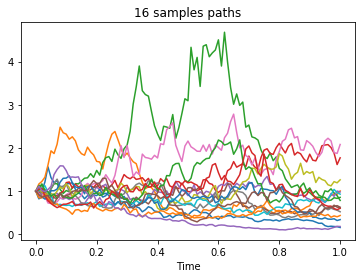

In [7]:
for i in range(16):
    plt.plot(t, Create_paths(100000000, M)[i])
plt.title("16 samples paths")
plt.xlabel("Time")

In [0]:
# input time and path as placeholders
path = tf.placeholder(dtype=tf.float32, shape=[M,steps+1])
time = tf.placeholder(dtype = tf.float32, shape = [M, steps +1 + 1]) # extra after T

## True Solution and Terminal Condition

 A closed-form solution is available in this case:
$$f(Y_t) = e^{-r(T-t)} \left(G_t^{t/T}y_t^{1 - t/T} e^{\bar{\mu} + \bar{\sigma}^2/2} \Phi(d_1) - K\Phi(d_2) \right),$$
where $\Phi$ is the cumulative distribution function of the standard normal,
\begin{align}
G_t &= \exp\left\{\frac{1}{t} \int_0^t \log y_u du \right\}\\
\bar{\mu} &= \left(r - q - \frac{\sigma^2}{2}\right)\frac{1}{2T}(T-t)^2,\\
\bar{\sigma} &= \frac{\sigma}{T} \sqrt{\frac{1}{3}(T-t)^3},\\
d_2 &= \frac{(t/T) \log G_t + \left(1 - t/T\right) \log y_t + \bar{\mu} - \log K}{\bar{\sigma}},\\
d_1 &= d_2 + \bar{\sigma}.
\end{align}
In the numerical examples below, we fix the strike price to $K = 0.4$. 

In [0]:
def true_solution(apath):
    '''
    Givin a path, it outputs the true solution.
    '''
    G = 1
    mu_bar = (r-q-sigma**2/2)/2/T * (T-t[0])**2
    sigma_bar = sigma/T * np.sqrt(1/3*(T-t[0])**3)
    d_2 = 1/sigma_bar * (t[0]/T * np.log(G) + (1 - t[0]/T) * np.log(apath[0]) + mu_bar - np.log(Strike))
    d_1 = d_2 + sigma_bar
    true_solution = [np.exp(-r*(T - t[0])) * ( G**(t[0]/T) * (apath[0] **(1-t[0]/T)) * np.exp(mu_bar + sigma_bar**2/2) * norm.cdf(d_1) 
                    - Strike * norm.cdf(d_2))]
    
    for k in range(1, steps+1):
        G = np.exp(1/t[k] * np.sum((np.log(apath[1:k+1]) + np.log(apath[:k]) )/2)*dt)
        mu_bar = (r-q-sigma**2/2)/2/T * (T-t[k])**2
        sigma_bar = sigma/T * np.sqrt(1/3*(T-t[k])**3)
        d_2 = 1/sigma_bar * (t[k]/T * np.log(G) + (1 - t[k]/T) * np.log(apath[k]) + mu_bar - np.log(Strike))
        d_1 = d_2 + sigma_bar
        true_solution.append(np.exp(-r*(T - t[k])) * (G**(t[k]/T) * (apath[k] **(1-t[k]/T)) * np.exp(mu_bar + sigma_bar**2/2) * norm.cdf(d_1) 
                        - Strike * norm.cdf(d_2)))

    return true_solution

In [0]:
def terminal_condition(apath):
    '''
    Givin a path, it outputs the terminal condition g(Y_T).
    '''
    
    return np.maximum(np.exp(1/T*sum( (np.log(apath[1:]) + np.log(apath[:-1]) )/2)*dt) - Strike,0)

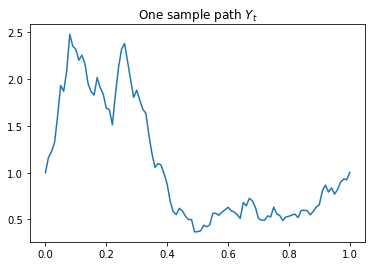

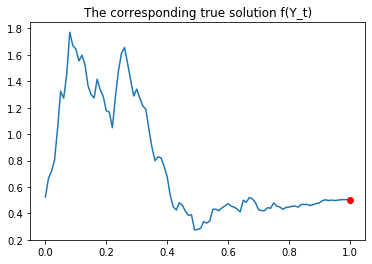

In [11]:
# for example given a GBM path
path1 = Create_paths(100000000, M)[1]
plt.plot(t, path1)
plt.title("One sample path $Y_t$")
plt.show()

plt.plot(t, true_solution(path1))
plt.plot(T, terminal_condition(path1), "ro")
plt.title("The corresponding true solution f(Y_t)")
plt.show()

## Neural Network Setup

The path-dependent function $f(X_t)$ is been approximated by a combination of LSTM and a feedforward neural network.

In [12]:
n_a = 128 # number of hidden neurons in the LSTM network
LSTM_cell = LSTM(n_a, return_state = True) # This is used to capture the long term dependency

# This feedforward neural network is used to compute the derivatives.
# input dimension is (1+1+n_a) = (space, time, path (which is characterized by n_a hidden neurons))
NN = Sequential([
    Dense(128, input_shape=(1+1+n_a,)),
    Activation('tanh'),
    Dense(128),
    Activation('tanh'),
    Dense(128),
    Activation('tanh'),
    Dense(1)
])

## Objective Function

\begin{align}\label{eq:loss_NM}
J_{N,M}(\theta) = \frac{1}{M} \frac{1}{N}\sum_{j=1}^M \sum_{i=0}^N \left(\Delta_{t} u(Y^{(j)}_{t_i};\theta) + L u(Y^{(j)}_{t_i};\theta)\right)^2 +  \frac{1}{M}\sum_{j=1}^M \left(u(Y^{(j)}_{t_N}; \theta) - g(Y_{t_N}^{(j)}) \right)^2.
\end{align}

In [0]:
def loss_function(time,path, M):
    
    a = tf.Variable(tf.zeros([M, n_a]), trainable=False)
    c = tf.Variable(tf.zeros([M, n_a]), trainable=False)

##. Approximate f(X_{t_0})
    input_x = K.slice(path, [0,0], [M,1])
    input_t = K.slice(time, [0,0], [M,1])
    inputt_f = K.concatenate([input_x, input_t, a])
    f = NN(inputt_f)
                      
##.   calculate space derivatives
    bump = 0.01 * input_x
    input_x_up = input_x + bump
    inputt_up = K.concatenate([input_x_up, input_t, a])
    f_up = NN(inputt_up)
    input_x_down = input_x - bump
    inputt_down = K.concatenate([input_x_down, input_t, a])
    f_down = NN(inputt_down)
    partial_x_f = (f_up - f)/bump
    partial_xx_f = (f_up - 2*f + f_down)/bump/bump

##. Next LSTM cell
    input_x_reshape = tf.reshape(input_x, (M,1,1))
    input_t_reshape = tf.reshape(input_t, (M,1,1))
    inputt = K.concatenate([input_x_reshape, input_t_reshape])
    a, _, c = LSTM_cell(inputt, initial_state = [a, c])
    
##.   calculate time derivative
    input_t_time = K.slice(time, [0, 1], [M, 1])
    inputt_time = K.concatenate([input_x, input_t_time, a])
    f_flat = NN(inputt_time)
    partial_t_f = (f_flat - f)/dt
    
    Loss = tf.reduce_sum(tf.square(partial_t_f + (r-q)*input_x * partial_x_f + 0.5 * sigma**2 * input_x **2 * partial_xx_f - r * f)) 

    solution = f
    time_derivative = partial_t_f 
    space_derivative = partial_x_f
    space_2nd_derivative = partial_xx_f

    #############################################################################
    for i in range(1, steps+1): # Iterate through every timestep
        
        ##. Approximate f(X_{t_i})
        input_x = K.slice(path, [0,i], [M,1])
        input_t = K.slice(time, [0,i], [M,1])
        inputt_f = K.concatenate([input_x, input_t, a])
        f = NN(inputt_f)
        
        ##. calculate space derivative
        bump = 0.01 * input_x
        input_x_up = input_x + bump
        inputt_up = K.concatenate([input_x_up, input_t, a])
        f_up = NN(inputt_up)
        input_x_down = input_x - bump
        inputt_down = K.concatenate([input_x_down, input_t, a])
        f_down = NN(inputt_down)
        partial_x_f = (f_up - f)/bump
        partial_xx_f = (f_up - 2*f + f_down)/bump/bump
    
        ##. Next LSTM cell
        input_x_reshape = tf.reshape(input_x, (M,1,1))
        input_t_reshape = tf.reshape(input_t, (M,1,1))
        inputt = K.concatenate([input_x_reshape, input_t_reshape])
        a, _, c = LSTM_cell(inputt, initial_state = [a, c])

        ##. calculate time derivative
        input_t_time = K.slice(time, [0, i+1], [M, 1])
        inputt_time = K.concatenate([input_x, input_t_time, a])
        f_flat = NN(inputt_time)
        partial_t_f = (f_flat - f)/dt
        
        Loss += tf.reduce_sum(tf.square(partial_t_f + (r-q) * input_x * partial_x_f + 0.5*sigma**2 * input_x **2 *partial_xx_f - r* f)) 

        solution = K.concatenate([solution, f]) 
        time_derivative = K.concatenate([time_derivative, partial_t_f]) 
        space_derivative = K.concatenate([space_derivative, partial_x_f])
        space_2nd_derivative = K.concatenate([space_2nd_derivative, partial_xx_f])

    #############################################################################
    ##. Terminal cost
    Loss += tf.reduce_sum( tf.square( f - tf.math.maximum(tf.exp(1/T*tf.reduce_sum((tf.log(path[:,1:]) + tf.log(path[:, :-1]))/2 * dt, axis= 1, keepdims=True))- Strike, 0)))*steps

    return Loss/M/steps, solution, time_derivative, space_derivative, space_2nd_derivative

## SGD

In [0]:
Epoch = 5000+1
# Epoch = 20000+1

In [0]:
loss, solution, time_derivative, space_derivative, space_2nd_derivative = loss_function(time, path, M)

In [16]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
# exponential decay learning rate
learning_rate = tf.maximum(tf.train.exponential_decay(starter_learning_rate, global_step, 50, 0.98, staircase=True), tf.constant(0.00001))
# adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm=5.0)
train_op = optimizer.minimize(loss, global_step=global_step)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

In [0]:
np.random.seed(8)
# GBM
path_test = Create_paths(100000000, M)
time_feed = generate_t(T, steps, M)
pred_dict = {path: path_test, time: time_feed}

# Linear
path_test2 = np.tile(np.linspace(2, 1e-6, steps+1), (M,1))
pred_dict2 = {path: path_test2, time: time_feed}

train_loss_list = []
test_loss_list = []

1th Epoch:
traing loss is 8.235598943429068e-05, test loss is 5.934645014349371e-05, and learning rate is 0.00017588013724889606, elapsed is 0.4416697025299072.
 


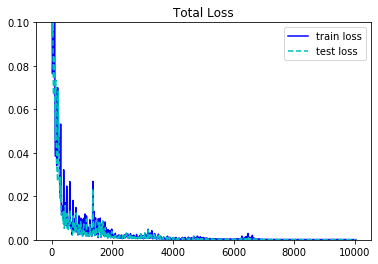

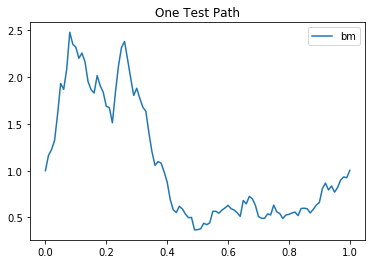

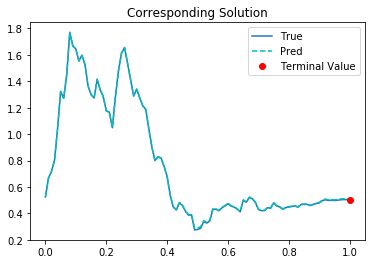

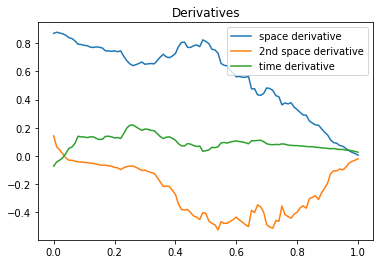

11th Epoch:
traing loss is 0.0001441812637494877, test loss is 6.760386168025434e-05, and learning rate is 0.00017588013724889606, elapsed is 5.126914024353027.
 
21th Epoch:
traing loss is 8.183622412616387e-05, test loss is 6.540093454532325e-05, and learning rate is 0.00017588013724889606, elapsed is 4.375871658325195.
 
31th Epoch:
traing loss is 4.542534225038253e-05, test loss is 6.218118505785242e-05, and learning rate is 0.00017588013724889606, elapsed is 4.402101993560791.
 
41th Epoch:
traing loss is 5.728014366468415e-05, test loss is 5.986193718854338e-05, and learning rate is 0.00017588013724889606, elapsed is 4.4154298305511475.
 
51th Epoch:
traing loss is 4.749622166855261e-05, test loss is 5.980048808851279e-05, and learning rate is 0.00017236254643648863, elapsed is 4.4098005294799805.
 
61th Epoch:
traing loss is 8.02898284746334e-05, test loss is 5.9569731092778966e-05, and learning rate is 0.00017236254643648863, elapsed is 4.401032447814941.
 
71th Epoch:
traing l

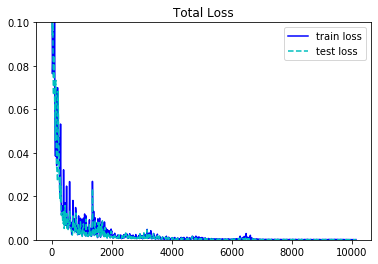

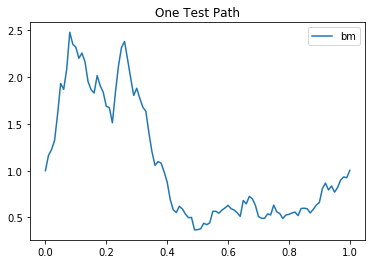

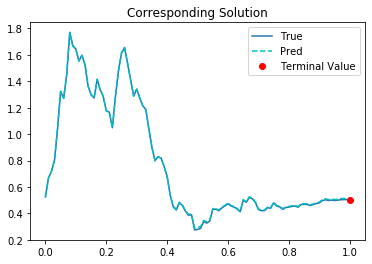

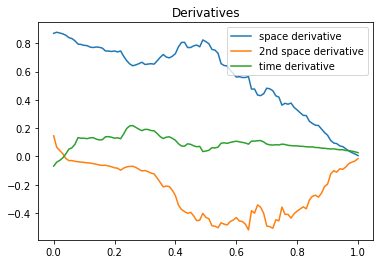

111th Epoch:
traing loss is 0.0001259104028576985, test loss is 6.265917181735858e-05, and learning rate is 0.00016891529958229512, elapsed is 5.208164215087891.
 
121th Epoch:
traing loss is 6.711589958285913e-05, test loss is 5.8930585510097444e-05, and learning rate is 0.00016891529958229512, elapsed is 4.373842000961304.
 
131th Epoch:
traing loss is 4.2821084207389504e-05, test loss is 5.9331523516448215e-05, and learning rate is 0.00016891529958229512, elapsed is 4.386112928390503.
 
141th Epoch:
traing loss is 5.8290846936870366e-05, test loss is 5.8229579735780135e-05, and learning rate is 0.00016891529958229512, elapsed is 4.3790178298950195.
 
151th Epoch:
traing loss is 4.541622911347076e-05, test loss is 5.767383481725119e-05, and learning rate is 0.0001655369997024536, elapsed is 4.382884740829468.
 
161th Epoch:
traing loss is 6.919386214576662e-05, test loss is 5.8381501730764285e-05, and learning rate is 0.0001655369997024536, elapsed is 4.419282674789429.
 
171th Epoch

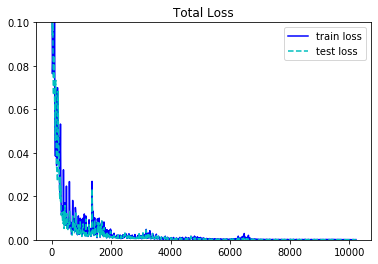

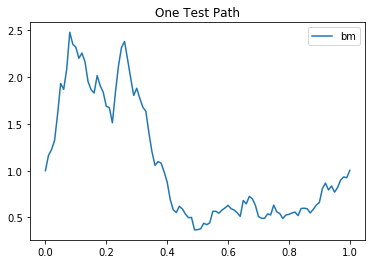

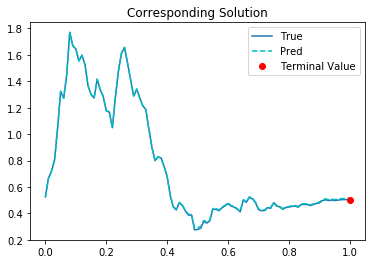

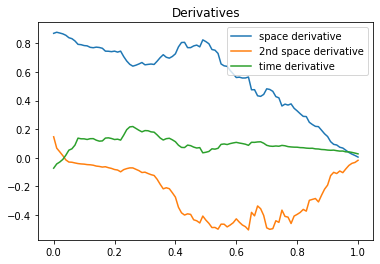

211th Epoch:
traing loss is 0.00012839253759011626, test loss is 6.032001329003833e-05, and learning rate is 0.00016222627891693264, elapsed is 5.11392068862915.
 
221th Epoch:
traing loss is 6.974655843805522e-05, test loss is 5.9228950703982264e-05, and learning rate is 0.00016222627891693264, elapsed is 4.37374472618103.
 
231th Epoch:
traing loss is 4.282121153664775e-05, test loss is 5.892504486837424e-05, and learning rate is 0.00016222627891693264, elapsed is 4.367738485336304.
 
241th Epoch:
traing loss is 5.337786933523603e-05, test loss is 5.7448352890787646e-05, and learning rate is 0.00016222627891693264, elapsed is 4.396795749664307.
 
251th Epoch:
traing loss is 4.4771601096726954e-05, test loss is 5.764489833381958e-05, and learning rate is 0.00015898174024187028, elapsed is 4.390486240386963.
 
261th Epoch:
traing loss is 7.493032899219543e-05, test loss is 5.7234261475969106e-05, and learning rate is 0.00015898174024187028, elapsed is 4.413332939147949.
 
271th Epoch:


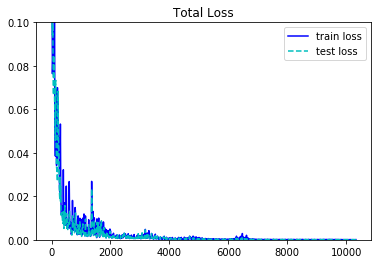

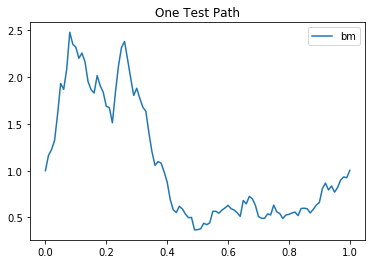

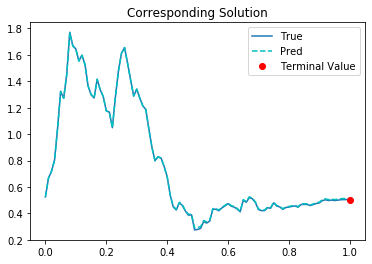

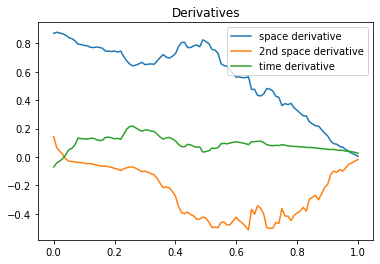

311th Epoch:
traing loss is 0.0001220316844410263, test loss is 6.092197145335376e-05, and learning rate is 0.0001558020885568112, elapsed is 5.1849524974823.
 
321th Epoch:
traing loss is 6.666078843409196e-05, test loss is 5.7999477576231584e-05, and learning rate is 0.0001558020885568112, elapsed is 4.381885528564453.
 
331th Epoch:
traing loss is 4.199072645860724e-05, test loss is 5.7829442084766924e-05, and learning rate is 0.0001558020885568112, elapsed is 4.420072793960571.
 
341th Epoch:
traing loss is 5.63416033401154e-05, test loss is 5.760720887337811e-05, and learning rate is 0.0001558020885568112, elapsed is 4.655421733856201.
 
351th Epoch:
traing loss is 4.4371223339112476e-05, test loss is 5.678029265254736e-05, and learning rate is 0.00015268605784513056, elapsed is 4.646907329559326.
 
361th Epoch:
traing loss is 6.729657616233453e-05, test loss is 5.687258089892566e-05, and learning rate is 0.00015268605784513056, elapsed is 4.683519601821899.
 
371th Epoch:
traing 

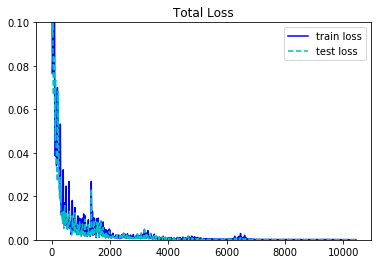

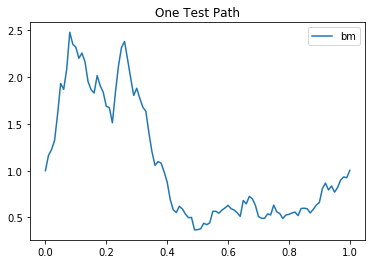

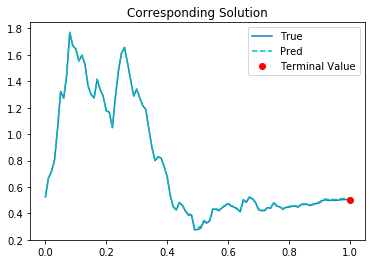

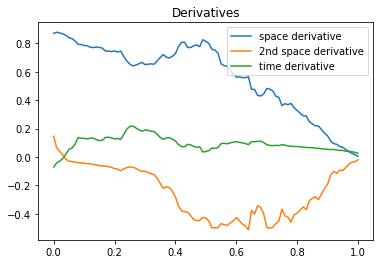

411th Epoch:
traing loss is 0.00012364884605631232, test loss is 5.8996771258534864e-05, and learning rate is 0.00014963233843445778, elapsed is 5.42330002784729.
 
421th Epoch:
traing loss is 6.959247548365965e-05, test loss is 5.8301808167016134e-05, and learning rate is 0.00014963233843445778, elapsed is 4.641433477401733.
 
431th Epoch:
traing loss is 4.191014886600897e-05, test loss is 5.766628237324767e-05, and learning rate is 0.00014963233843445778, elapsed is 4.606596231460571.
 
441th Epoch:
traing loss is 5.273660644888878e-05, test loss is 5.68138639209792e-05, and learning rate is 0.00014963233843445778, elapsed is 4.676162958145142.
 
451th Epoch:
traing loss is 4.367653309600428e-05, test loss is 5.629080260405317e-05, and learning rate is 0.00014663970796391368, elapsed is 4.4429051876068115.
 
461th Epoch:
traing loss is 7.140568777685985e-05, test loss is 5.5922566389199346e-05, and learning rate is 0.00014663970796391368, elapsed is 4.490388870239258.
 
471th Epoch:


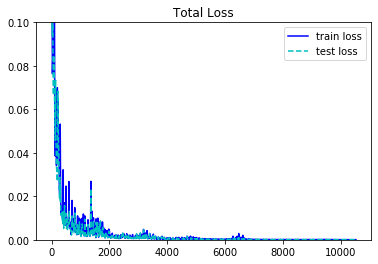

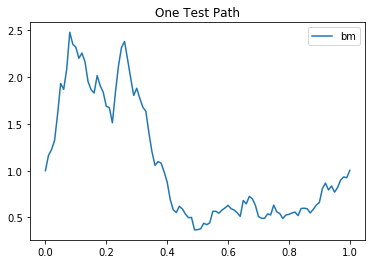

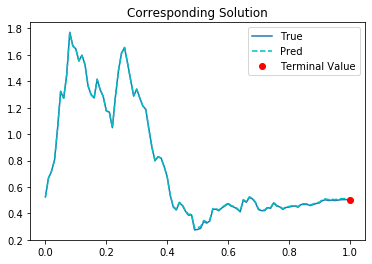

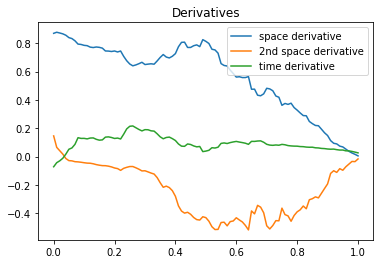

511th Epoch:
traing loss is 0.00011681803152896464, test loss is 5.8495170378591865e-05, and learning rate is 0.00014370691496878862, elapsed is 5.1966753005981445.
 
521th Epoch:
traing loss is 6.586292147403583e-05, test loss is 5.6538385251769796e-05, and learning rate is 0.00014370691496878862, elapsed is 4.503978729248047.
 
531th Epoch:
traing loss is 4.062219159095548e-05, test loss is 5.636711648548953e-05, and learning rate is 0.00014370691496878862, elapsed is 4.476806640625.
 
541th Epoch:
traing loss is 5.563074228120968e-05, test loss is 5.7323402870679274e-05, and learning rate is 0.00014370691496878862, elapsed is 4.595372915267944.
 
551th Epoch:
traing loss is 4.291166260372847e-05, test loss is 5.545621752389707e-05, and learning rate is 0.0001408327661920339, elapsed is 4.519526481628418.
 
561th Epoch:
traing loss is 6.635444151470438e-05, test loss is 5.525856249732897e-05, and learning rate is 0.0001408327661920339, elapsed is 4.4805755615234375.
 
571th Epoch:
tr

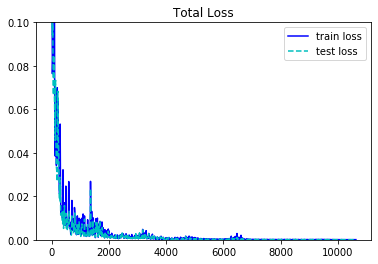

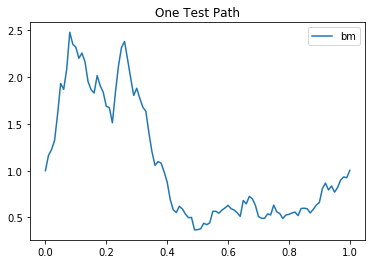

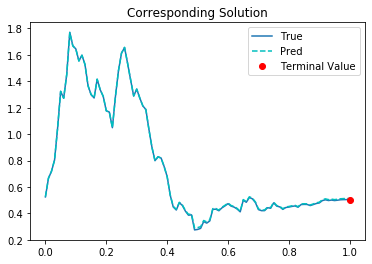

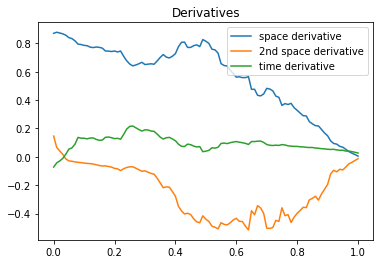

611th Epoch:
traing loss is 0.00011845125845866278, test loss is 5.65244336030446e-05, and learning rate is 0.00013801612658426166, elapsed is 5.405778408050537.
 
621th Epoch:
traing loss is 6.72451060381718e-05, test loss is 5.626294660032727e-05, and learning rate is 0.00013801612658426166, elapsed is 4.533246040344238.
 
631th Epoch:
traing loss is 3.992605343228206e-05, test loss is 5.585289545706473e-05, and learning rate is 0.00013801612658426166, elapsed is 4.511498212814331.
 
641th Epoch:
traing loss is 5.275233706925064e-05, test loss is 5.7162600569427013e-05, and learning rate is 0.00013801612658426166, elapsed is 4.4644615650177.
 
651th Epoch:
traing loss is 4.200285911792889e-05, test loss is 5.4930402257014066e-05, and learning rate is 0.0001352558028884232, elapsed is 4.428889989852905.
 
661th Epoch:
traing loss is 6.984420906519517e-05, test loss is 5.533954026759602e-05, and learning rate is 0.0001352558028884232, elapsed is 4.441988229751587.
 
671th Epoch:
traing

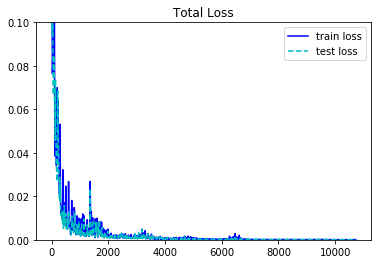

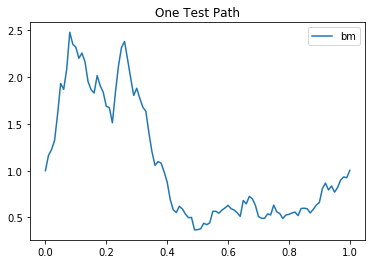

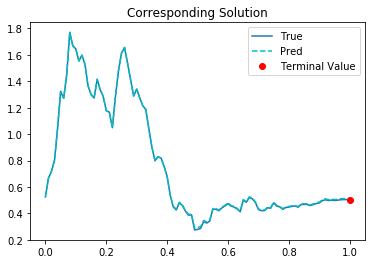

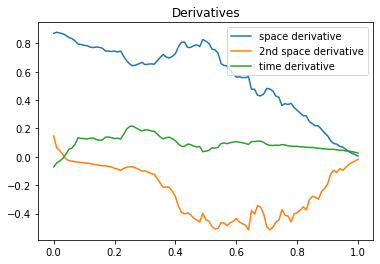

711th Epoch:
traing loss is 0.00011493105557747185, test loss is 5.5864649766590446e-05, and learning rate is 0.00013255068915896118, elapsed is 5.177359104156494.
 
721th Epoch:
traing loss is 6.47695196676068e-05, test loss is 5.4571872169617563e-05, and learning rate is 0.00013255068915896118, elapsed is 4.478381395339966.
 
731th Epoch:
traing loss is 3.929662852897309e-05, test loss is 5.458746090880595e-05, and learning rate is 0.00013255068915896118, elapsed is 4.470689535140991.
 
741th Epoch:
traing loss is 5.51434131921269e-05, test loss is 5.701824920834042e-05, and learning rate is 0.00013255068915896118, elapsed is 4.461841106414795.
 
751th Epoch:
traing loss is 4.149576125200838e-05, test loss is 5.39419379492756e-05, and learning rate is 0.00012989969400223345, elapsed is 4.417133331298828.
 
761th Epoch:
traing loss is 6.57361451885663e-05, test loss is 5.463405977934599e-05, and learning rate is 0.00012989969400223345, elapsed is 4.445551156997681.
 
771th Epoch:
trai

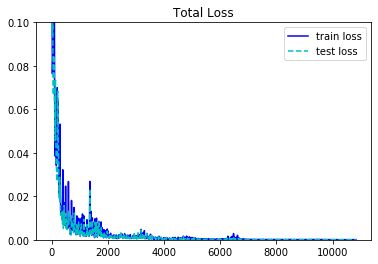

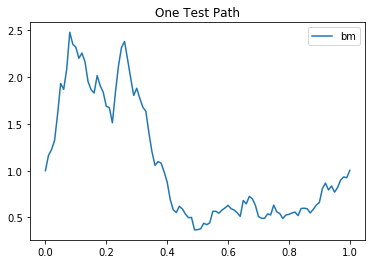

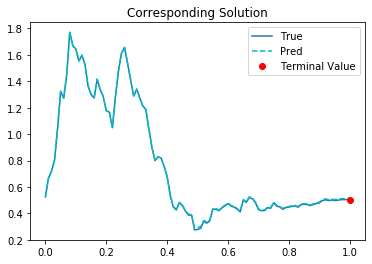

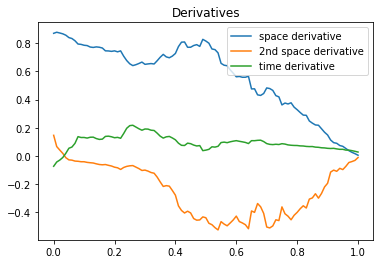

811th Epoch:
traing loss is 0.00011535916564753279, test loss is 5.459320163936354e-05, and learning rate is 0.0001273016823688522, elapsed is 5.262925386428833.
 
821th Epoch:
traing loss is 6.606257375096902e-05, test loss is 5.4620119044557214e-05, and learning rate is 0.0001273016823688522, elapsed is 4.459039211273193.
 
831th Epoch:
traing loss is 3.90949280699715e-05, test loss is 5.451425022329204e-05, and learning rate is 0.0001273016823688522, elapsed is 4.562462329864502.
 
841th Epoch:
traing loss is 5.249467722023837e-05, test loss is 5.6144028349081054e-05, and learning rate is 0.0001273016823688522, elapsed is 4.5235350131988525.
 
851th Epoch:
traing loss is 4.0640461520524696e-05, test loss is 5.3628104069503024e-05, and learning rate is 0.00012475565017666668, elapsed is 4.452694892883301.
 
861th Epoch:
traing loss is 6.967454100959003e-05, test loss is 5.581021468969993e-05, and learning rate is 0.00012475565017666668, elapsed is 4.445814609527588.
 
871th Epoch:
tr

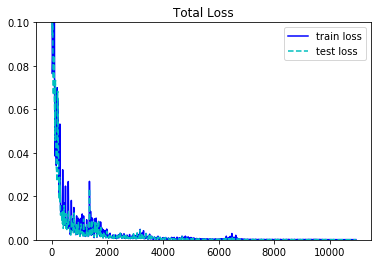

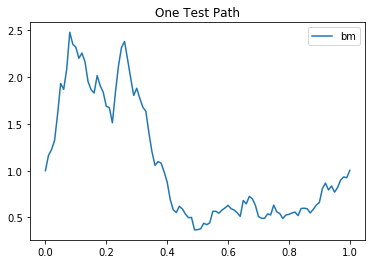

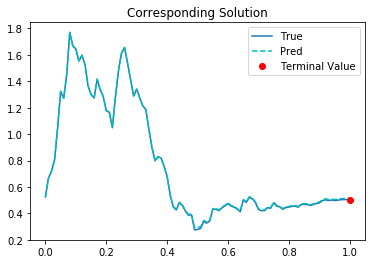

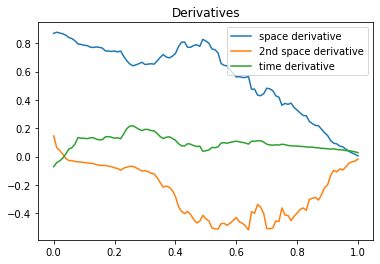

911th Epoch:
traing loss is 0.00011442832328611985, test loss is 5.4376545449486e-05, and learning rate is 0.0001222605351358652, elapsed is 5.2370078563690186.
 
921th Epoch:
traing loss is 6.373959331540391e-05, test loss is 5.346011312212795e-05, and learning rate is 0.0001222605351358652, elapsed is 4.456014156341553.
 
931th Epoch:
traing loss is 3.866932456730865e-05, test loss is 5.4125262977322564e-05, and learning rate is 0.0001222605351358652, elapsed is 4.480820178985596.
 
941th Epoch:
traing loss is 5.393594619818032e-05, test loss is 5.646347926813178e-05, and learning rate is 0.0001222605351358652, elapsed is 4.582036018371582.
 
951th Epoch:
traing loss is 4.019199695903808e-05, test loss is 5.316184979164973e-05, and learning rate is 0.00011981533316429704, elapsed is 4.513377904891968.
 
961th Epoch:
traing loss is 6.632553413510323e-05, test loss is 5.493896242114715e-05, and learning rate is 0.00011981533316429704, elapsed is 4.465122938156128.
 
971th Epoch:
traing

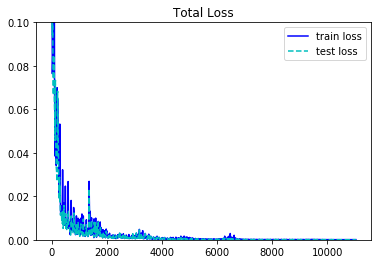

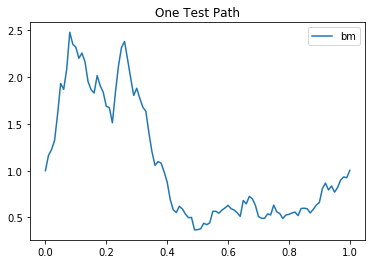

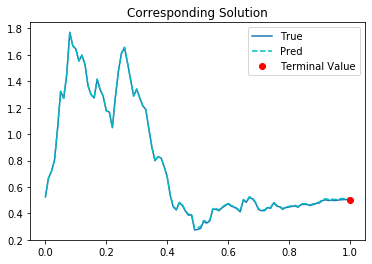

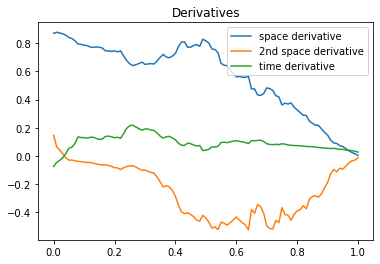

1011th Epoch:
traing loss is 0.00011400372750358656, test loss is 5.37391024408862e-05, and learning rate is 0.00011741902562789619, elapsed is 5.346879720687866.
 
1021th Epoch:
traing loss is 6.477446731878445e-05, test loss is 5.3569008741760626e-05, and learning rate is 0.00011741902562789619, elapsed is 4.704349040985107.
 
1031th Epoch:
traing loss is 3.879008363583125e-05, test loss is 5.3888503316557035e-05, and learning rate is 0.00011741902562789619, elapsed is 4.441854000091553.
 
1041th Epoch:
traing loss is 5.1326733228052035e-05, test loss is 5.5532975238747895e-05, and learning rate is 0.00011741902562789619, elapsed is 4.46606183052063.
 
1051th Epoch:
traing loss is 4.0369966882281005e-05, test loss is 5.375903856474906e-05, and learning rate is 0.0001150706666521728, elapsed is 4.446732521057129.
 
1061th Epoch:
traing loss is 7.12859837221913e-05, test loss is 5.721444176742807e-05, and learning rate is 0.0001150706666521728, elapsed is 4.441573619842529.
 
1071th Ep

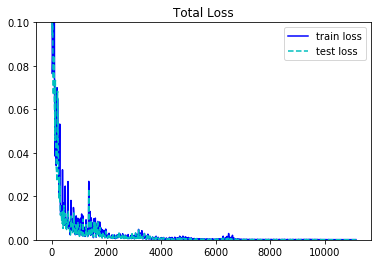

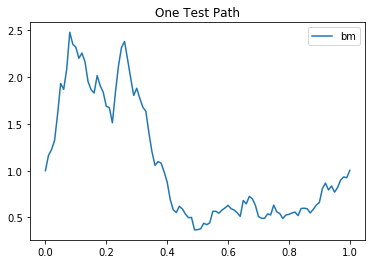

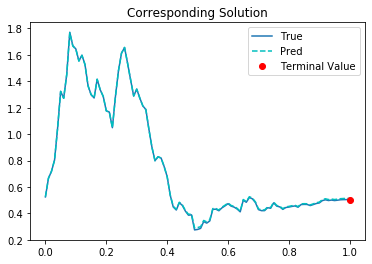

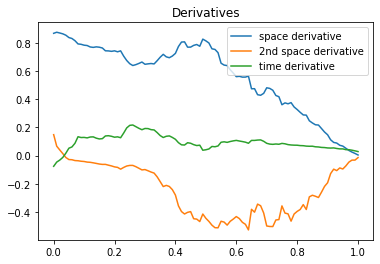

1111th Epoch:
traing loss is 0.00011066367733292282, test loss is 5.3990537708159536e-05, and learning rate is 0.0001127692376030609, elapsed is 5.265592336654663.
 
1121th Epoch:
traing loss is 6.256805500015616e-05, test loss is 5.298658288666047e-05, and learning rate is 0.0001127692376030609, elapsed is 4.617129325866699.
 
1131th Epoch:
traing loss is 3.792504867305979e-05, test loss is 5.3131105232751e-05, and learning rate is 0.0001127692376030609, elapsed is 4.418307065963745.
 
1141th Epoch:
traing loss is 5.3342748287832364e-05, test loss is 5.632881948258728e-05, and learning rate is 0.0001127692376030609, elapsed is 4.408554553985596.
 
1151th Epoch:
traing loss is 4.010298289358616e-05, test loss is 5.3745399782201275e-05, and learning rate is 0.00011051385081373155, elapsed is 4.428258419036865.
 
1161th Epoch:
traing loss is 6.828534242231399e-05, test loss is 5.676964792655781e-05, and learning rate is 0.00011051385081373155, elapsed is 4.453700065612793.
 
1171th Epoch

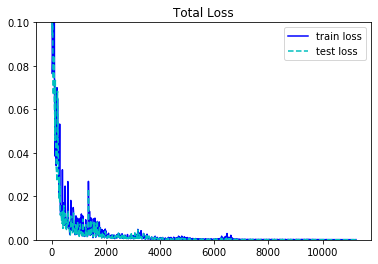

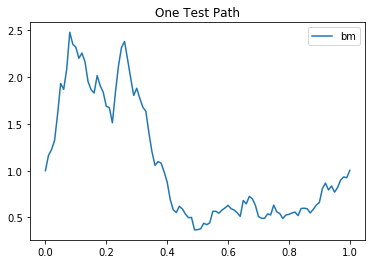

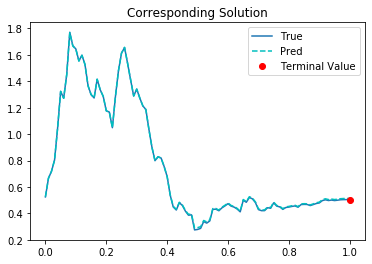

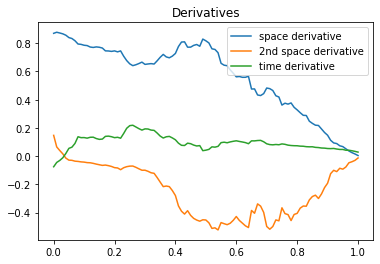

1211th Epoch:
traing loss is 0.00011035759234800935, test loss is 5.354077075025998e-05, and learning rate is 0.00010830358223756775, elapsed is 5.178425073623657.
 
1221th Epoch:
traing loss is 6.324418791336939e-05, test loss is 5.3005140216555446e-05, and learning rate is 0.00010830358223756775, elapsed is 4.48613977432251.
 
1231th Epoch:
traing loss is 3.781744817388244e-05, test loss is 5.310873530106619e-05, and learning rate is 0.00010830358223756775, elapsed is 4.442108869552612.
 
1241th Epoch:
traing loss is 5.1265313231851906e-05, test loss is 5.564228558796458e-05, and learning rate is 0.00010830358223756775, elapsed is 4.415909051895142.
 
1251th Epoch:
traing loss is 4.0623861423227936e-05, test loss is 5.505897934199311e-05, and learning rate is 0.00010613751510391012, elapsed is 4.411679267883301.
 
1261th Epoch:
traing loss is 7.227936293929815e-05, test loss is 5.8275702031096444e-05, and learning rate is 0.00010613751510391012, elapsed is 4.408096790313721.
 
1271th

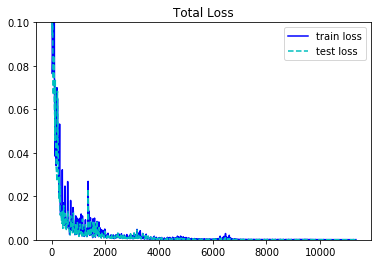

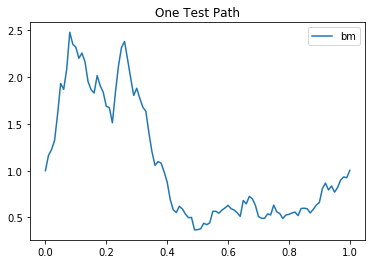

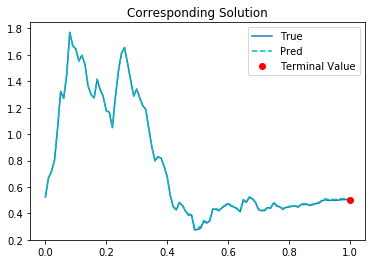

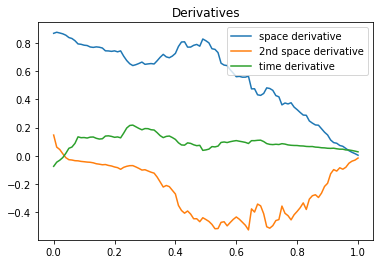

1311th Epoch:
traing loss is 0.00010689972987165675, test loss is 5.42991328984499e-05, and learning rate is 0.00010401476902188733, elapsed is 5.141662120819092.
 
1321th Epoch:
traing loss is 6.146583473309875e-05, test loss is 5.1944763981737196e-05, and learning rate is 0.00010401476902188733, elapsed is 4.405407190322876.
 
1331th Epoch:
traing loss is 3.7637975765392184e-05, test loss is 5.252291521173902e-05, and learning rate is 0.00010401476902188733, elapsed is 4.3887903690338135.
 
1341th Epoch:
traing loss is 5.311284985509701e-05, test loss is 5.5872405937407166e-05, and learning rate is 0.00010401476902188733, elapsed is 4.435050964355469.
 
1351th Epoch:
traing loss is 4.1658644477138296e-05, test loss is 5.6017262977547944e-05, and learning rate is 0.00010193447087658569, elapsed is 4.449269533157349.
 
1361th Epoch:
traing loss is 6.64989638607949e-05, test loss is 5.5730328313075006e-05, and learning rate is 0.00010193447087658569, elapsed is 4.451746463775635.
 
1371

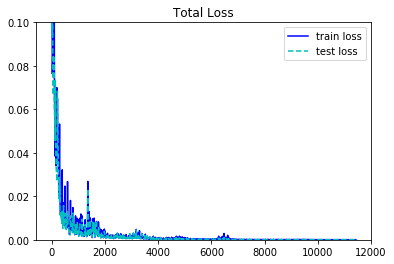

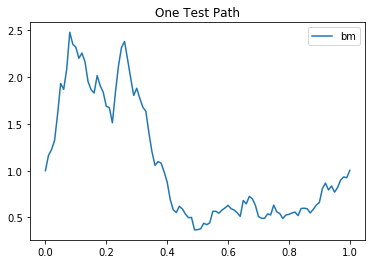

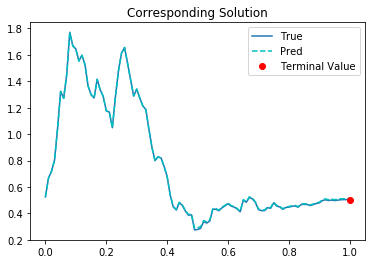

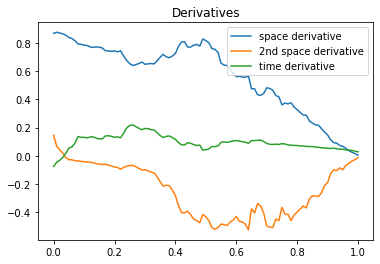

1411th Epoch:
traing loss is 0.00010839365131687373, test loss is 5.424924529506825e-05, and learning rate is 9.98957984847948e-05, elapsed is 5.117638826370239.
 
1421th Epoch:
traing loss is 6.269863661145791e-05, test loss is 5.185843474464491e-05, and learning rate is 9.98957984847948e-05, elapsed is 4.463180780410767.
 
1431th Epoch:
traing loss is 3.8392568967537954e-05, test loss is 5.3151372412685305e-05, and learning rate is 9.98957984847948e-05, elapsed is 4.413688659667969.
 
1441th Epoch:
traing loss is 4.953846291755326e-05, test loss is 5.3882500651525334e-05, and learning rate is 9.98957984847948e-05, elapsed is 4.544898748397827.
 
1451th Epoch:
traing loss is 4.261755748302676e-05, test loss is 5.784622408100404e-05, and learning rate is 9.789787145564333e-05, elapsed is 4.5044105052948.
 
1461th Epoch:
traing loss is 6.860395660623908e-05, test loss is 5.503031934495084e-05, and learning rate is 9.789787145564333e-05, elapsed is 4.41907000541687.
 
1471th Epoch:
train

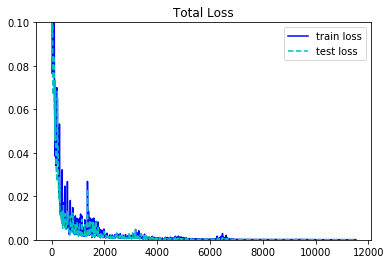

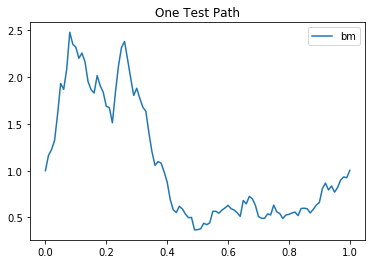

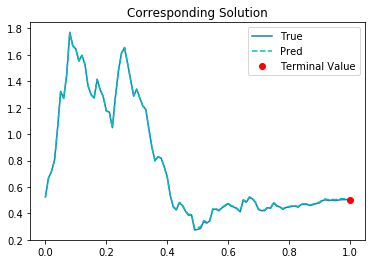

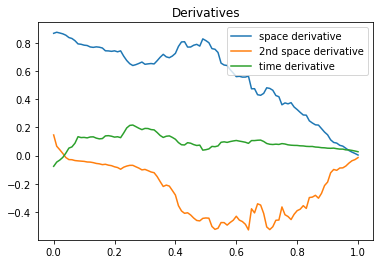

1511th Epoch:
traing loss is 0.0001039651469909586, test loss is 5.453921767184511e-05, and learning rate is 9.59399258135818e-05, elapsed is 5.147112131118774.
 
1521th Epoch:
traing loss is 6.063444379833527e-05, test loss is 5.099177724332549e-05, and learning rate is 9.59399258135818e-05, elapsed is 4.4154298305511475.
 
1531th Epoch:
traing loss is 3.7205812986940145e-05, test loss is 5.207813956076279e-05, and learning rate is 9.59399258135818e-05, elapsed is 4.435134649276733.
 
1541th Epoch:
traing loss is 5.1752402214333415e-05, test loss is 5.42686611879617e-05, and learning rate is 9.59399258135818e-05, elapsed is 4.425253629684448.
 
1551th Epoch:
traing loss is 4.3064093915745616e-05, test loss is 5.77436585444957e-05, and learning rate is 9.402111754752696e-05, elapsed is 4.4910218715667725.
 
1561th Epoch:
traing loss is 6.226103869266808e-05, test loss is 5.213648546487093e-05, and learning rate is 9.402111754752696e-05, elapsed is 4.469053268432617.
 
1571th Epoch:
tra

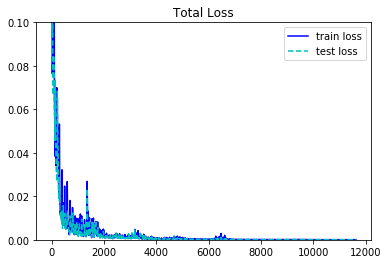

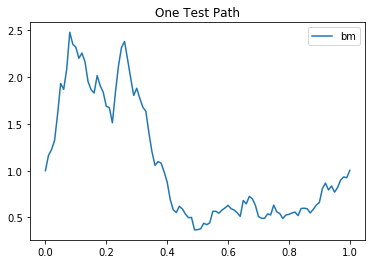

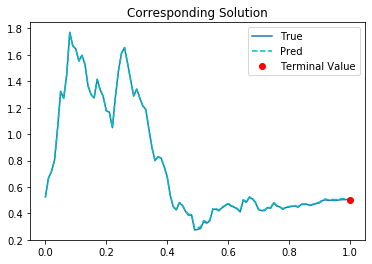

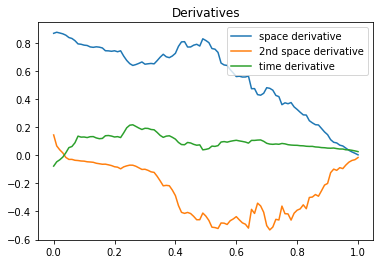

1611th Epoch:
traing loss is 0.00010421709885122254, test loss is 5.3447511163540184e-05, and learning rate is 9.214070450980216e-05, elapsed is 5.286941051483154.
 
1621th Epoch:
traing loss is 6.220304203452542e-05, test loss is 5.066747689852491e-05, and learning rate is 9.214070450980216e-05, elapsed is 4.4588611125946045.
 
1631th Epoch:
traing loss is 3.7587062251986936e-05, test loss is 5.1815208280459046e-05, and learning rate is 9.214070450980216e-05, elapsed is 4.421063184738159.
 
1641th Epoch:
traing loss is 4.789474041899666e-05, test loss is 5.172642704565078e-05, and learning rate is 9.214070450980216e-05, elapsed is 4.407998323440552.
 
1651th Epoch:
traing loss is 4.2602874600561336e-05, test loss is 5.8086839999305084e-05, and learning rate is 9.029788634506986e-05, elapsed is 4.422280311584473.
 
1661th Epoch:
traing loss is 6.383690924849361e-05, test loss is 5.139616405358538e-05, and learning rate is 9.029788634506986e-05, elapsed is 4.535478591918945.
 
1671th Ep

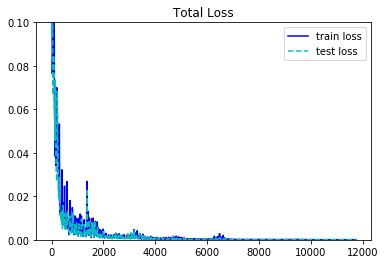

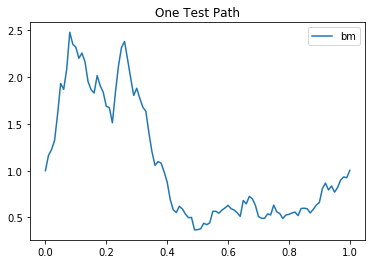

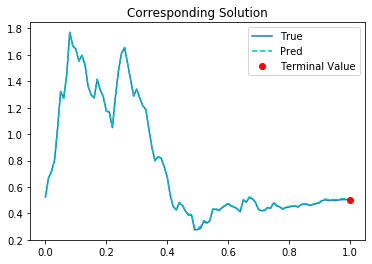

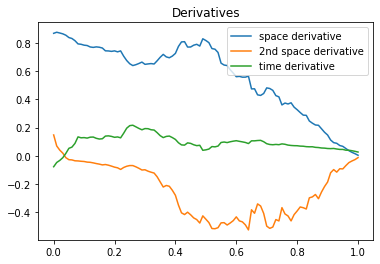

1711th Epoch:
traing loss is 0.00010027401003753766, test loss is 5.37259693373926e-05, and learning rate is 8.8491928181611e-05, elapsed is 5.184033632278442.
 
1721th Epoch:
traing loss is 5.990320642013103e-05, test loss is 5.036203219788149e-05, and learning rate is 8.8491928181611e-05, elapsed is 4.413068532943726.
 
1731th Epoch:
traing loss is 3.659196590888314e-05, test loss is 5.080196569906548e-05, and learning rate is 8.8491928181611e-05, elapsed is 4.437249422073364.
 
1741th Epoch:
traing loss is 5.072042768006213e-05, test loss is 5.294106085784733e-05, and learning rate is 8.8491928181611e-05, elapsed is 4.44867467880249.
 
1751th Epoch:
traing loss is 4.312373130233027e-05, test loss is 5.767529728473164e-05, and learning rate is 8.672209514770657e-05, elapsed is 4.428605079650879.
 
1761th Epoch:
traing loss is 5.916116788284853e-05, test loss is 5.0064412789652124e-05, and learning rate is 8.672209514770657e-05, elapsed is 4.451522350311279.
 
1771th Epoch:
traing los

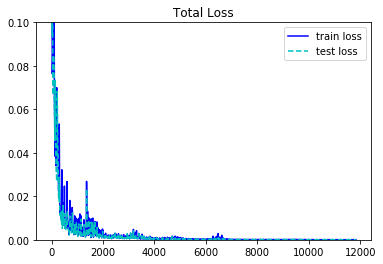

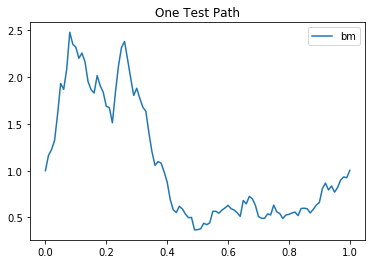

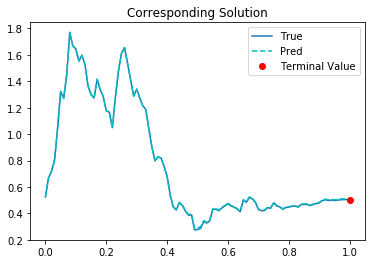

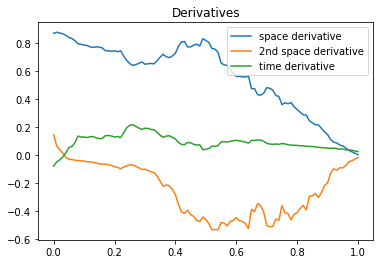

1811th Epoch:
traing loss is 0.00010274516534991562, test loss is 5.2689603762701154e-05, and learning rate is 8.498765964759514e-05, elapsed is 5.207959413528442.
 
1821th Epoch:
traing loss is 6.188330007717013e-05, test loss is 5.077931928099133e-05, and learning rate is 8.498765964759514e-05, elapsed is 4.530768632888794.
 
1831th Epoch:
traing loss is 3.677249696920626e-05, test loss is 5.070385668659583e-05, and learning rate is 8.498765964759514e-05, elapsed is 4.468764305114746.
 
1841th Epoch:
traing loss is 4.665552114602178e-05, test loss is 5.082984353066422e-05, and learning rate is 8.498765964759514e-05, elapsed is 4.4501142501831055.
 
1851th Epoch:
traing loss is 4.187703234492801e-05, test loss is 5.741823042626493e-05, and learning rate is 8.328790863743052e-05, elapsed is 4.435693979263306.
 
1861th Epoch:
traing loss is 6.133015267550945e-05, test loss is 4.995858762413263e-05, and learning rate is 8.328790863743052e-05, elapsed is 4.416820287704468.
 
1871th Epoch:

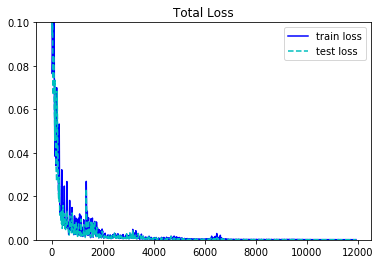

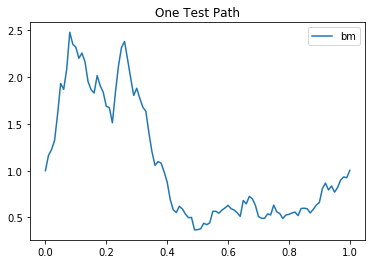

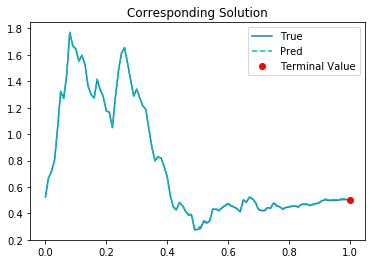

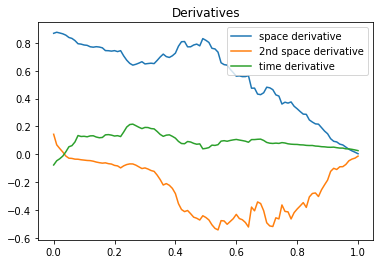

1911th Epoch:
traing loss is 9.840095299296081e-05, test loss is 5.256972144707106e-05, and learning rate is 8.162215090123937e-05, elapsed is 5.151013374328613.
 
1921th Epoch:
traing loss is 6.008841228322126e-05, test loss is 5.034854984842241e-05, and learning rate is 8.162215090123937e-05, elapsed is 4.3974268436431885.
 
1931th Epoch:
traing loss is 3.6227709642844275e-05, test loss is 4.992924732505344e-05, and learning rate is 8.162215090123937e-05, elapsed is 4.410964727401733.
 
1941th Epoch:
traing loss is 4.9725178541848436e-05, test loss is 5.1444480050122365e-05, and learning rate is 8.162215090123937e-05, elapsed is 4.457693099975586.
 
1951th Epoch:
traing loss is 4.2513209336902946e-05, test loss is 5.702130511053838e-05, and learning rate is 7.998970977496356e-05, elapsed is 4.54486346244812.
 
1961th Epoch:
traing loss is 5.795975812361576e-05, test loss is 4.909944618702866e-05, and learning rate is 7.998970977496356e-05, elapsed is 4.508314847946167.
 
1971th Epoch

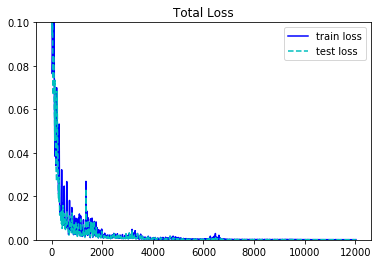

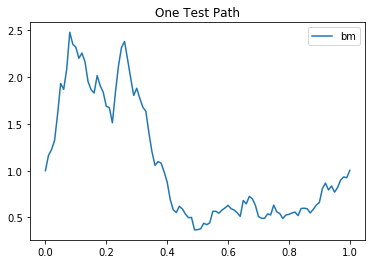

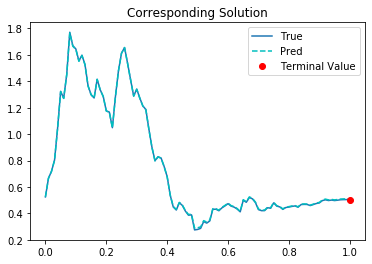

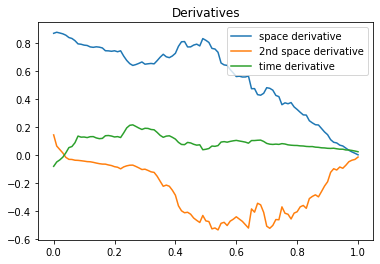

2011th Epoch:
traing loss is 0.00010122526146005839, test loss is 5.2677969506476074e-05, and learning rate is 7.838991587050259e-05, elapsed is 5.087059497833252.
 
2021th Epoch:
traing loss is 6.232112355064601e-05, test loss is 5.135606988915242e-05, and learning rate is 7.838991587050259e-05, elapsed is 4.444892406463623.
 
2031th Epoch:
traing loss is 3.646512413979508e-05, test loss is 4.9959697207668796e-05, and learning rate is 7.838991587050259e-05, elapsed is 4.443369388580322.
 
2041th Epoch:
traing loss is 4.5667646190850064e-05, test loss is 4.9703652621246874e-05, and learning rate is 7.838991587050259e-05, elapsed is 4.40180230140686.
 
2051th Epoch:
traing loss is 4.07961560995318e-05, test loss is 5.5931275710463524e-05, and learning rate is 7.682211435167119e-05, elapsed is 4.435206651687622.
 
2061th Epoch:
traing loss is 5.990946738165803e-05, test loss is 4.901291322312318e-05, and learning rate is 7.682211435167119e-05, elapsed is 4.402763605117798.
 
2071th Epoch

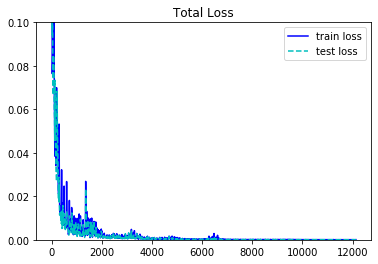

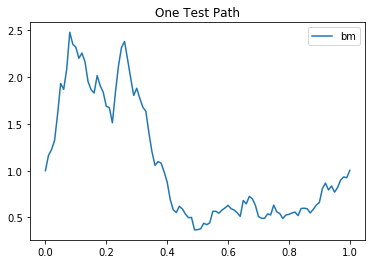

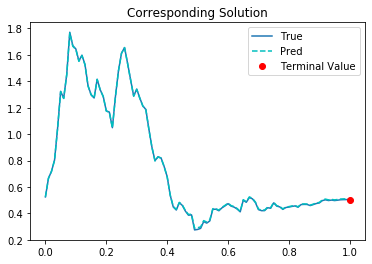

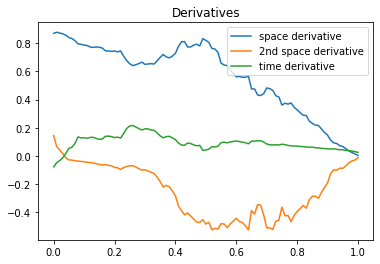

2111th Epoch:
traing loss is 9.687947749625891e-05, test loss is 5.273471469990909e-05, and learning rate is 7.528567221015692e-05, elapsed is 5.2053985595703125.
 
2121th Epoch:
traing loss is 6.068859147490002e-05, test loss is 5.148136187926866e-05, and learning rate is 7.528567221015692e-05, elapsed is 4.483676910400391.
 
2131th Epoch:
traing loss is 3.64974512194749e-05, test loss is 4.9784510338213295e-05, and learning rate is 7.528567221015692e-05, elapsed is 4.432896614074707.
 
2141th Epoch:
traing loss is 4.91623577545397e-05, test loss is 5.027141378377564e-05, and learning rate is 7.528567221015692e-05, elapsed is 4.39903450012207.
 
2151th Epoch:
traing loss is 4.138996882829815e-05, test loss is 5.5277458159253e-05, and learning rate is 7.377996371360496e-05, elapsed is 4.43779993057251.
 
2161th Epoch:
traing loss is 5.689762838301249e-05, test loss is 4.86603457829915e-05, and learning rate is 7.377996371360496e-05, elapsed is 4.427812576293945.
 
2171th Epoch:
traing 

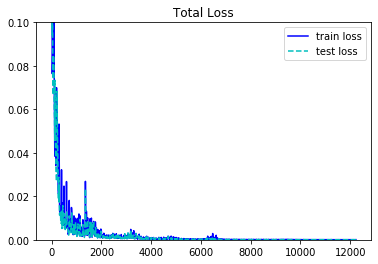

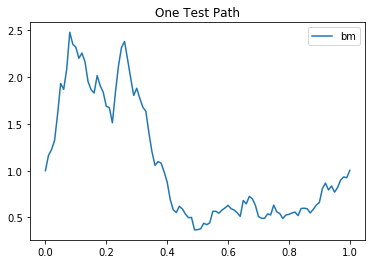

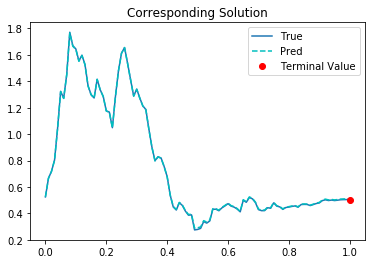

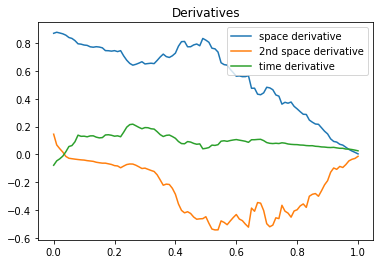

2211th Epoch:
traing loss is 9.809165931073949e-05, test loss is 5.2443323511397466e-05, and learning rate is 7.230436312966049e-05, elapsed is 5.167021989822388.
 
2221th Epoch:
traing loss is 6.286513962550089e-05, test loss is 5.2010876970598474e-05, and learning rate is 7.230436312966049e-05, elapsed is 4.51921534538269.
 
2231th Epoch:
traing loss is 3.7007397622801363e-05, test loss is 4.981176971341483e-05, and learning rate is 7.230436312966049e-05, elapsed is 4.4045374393463135.
 
2241th Epoch:
traing loss is 4.5060209231451154e-05, test loss is 4.902442015009001e-05, and learning rate is 7.230436312966049e-05, elapsed is 4.44857382774353.
 
2251th Epoch:
traing loss is 3.8423178921220824e-05, test loss is 5.295484879752621e-05, and learning rate is 7.085827382979915e-05, elapsed is 4.408292293548584.
 
2261th Epoch:
traing loss is 5.969696576357819e-05, test loss is 4.894832454738207e-05, and learning rate is 7.085827382979915e-05, elapsed is 4.402823448181152.
 
2271th Epoch

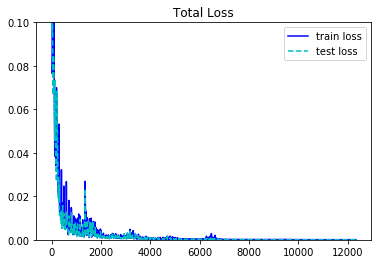

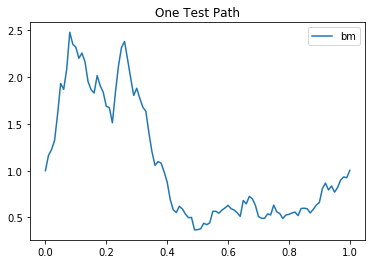

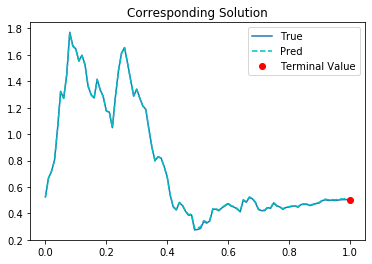

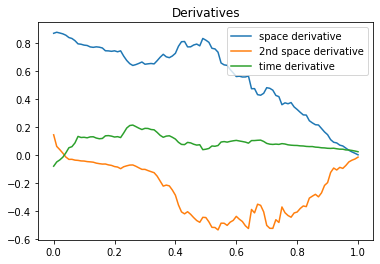

2311th Epoch:
traing loss is 9.378149843541905e-05, test loss is 5.267300002742559e-05, and learning rate is 6.944112101336941e-05, elapsed is 5.245486497879028.
 
2321th Epoch:
traing loss is 6.090412352932617e-05, test loss is 5.1884984713979065e-05, and learning rate is 6.944112101336941e-05, elapsed is 4.593114376068115.
 
2331th Epoch:
traing loss is 3.657702836790122e-05, test loss is 4.949483263771981e-05, and learning rate is 6.944112101336941e-05, elapsed is 4.534656047821045.
 
2341th Epoch:
traing loss is 4.870129851042293e-05, test loss is 4.972414899384603e-05, and learning rate is 6.944112101336941e-05, elapsed is 4.391779899597168.
 
2351th Epoch:
traing loss is 3.957781154895201e-05, test loss is 5.3075356845511124e-05, and learning rate is 6.805230077588931e-05, elapsed is 4.456418752670288.
 
2361th Epoch:
traing loss is 5.6766977650113404e-05, test loss is 4.8567246267339215e-05, and learning rate is 6.805230077588931e-05, elapsed is 4.443963527679443.
 
2371th Epoch

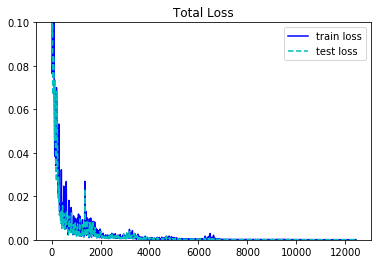

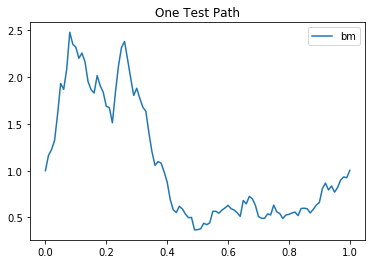

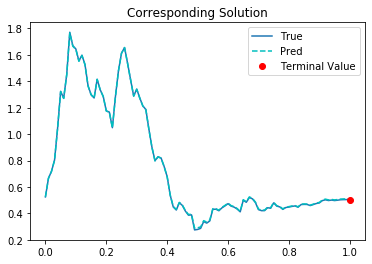

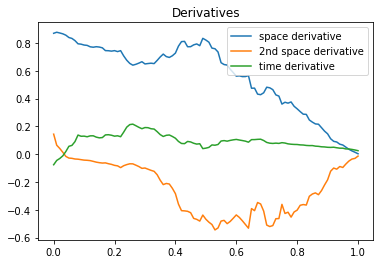

2411th Epoch:
traing loss is 9.634311572881415e-05, test loss is 5.180240623303689e-05, and learning rate is 6.669124559266493e-05, elapsed is 5.18554162979126.
 
2421th Epoch:
traing loss is 6.229169957805425e-05, test loss is 5.1845443522324786e-05, and learning rate is 6.669124559266493e-05, elapsed is 4.452585697174072.
 
2431th Epoch:
traing loss is 3.6685778468381613e-05, test loss is 4.934197204420343e-05, and learning rate is 6.669124559266493e-05, elapsed is 4.441928148269653.
 
2441th Epoch:
traing loss is 4.433244976098649e-05, test loss is 4.8920148401521146e-05, and learning rate is 6.669124559266493e-05, elapsed is 4.3756327629089355.
 
2451th Epoch:
traing loss is 3.679479050333612e-05, test loss is 5.0875609304057434e-05, and learning rate is 6.535742431879044e-05, elapsed is 4.4829301834106445.
 
2461th Epoch:
traing loss is 5.975647218292579e-05, test loss is 4.892644938081503e-05, and learning rate is 6.535742431879044e-05, elapsed is 4.444974422454834.
 
2471th Epoc

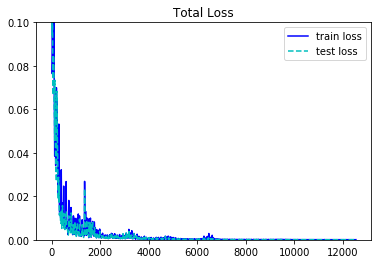

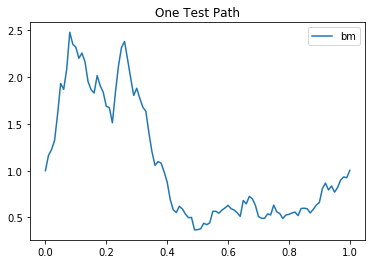

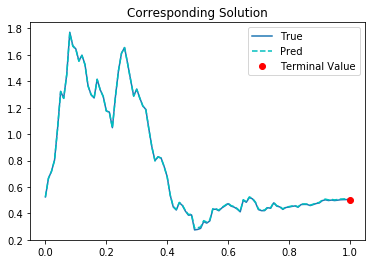

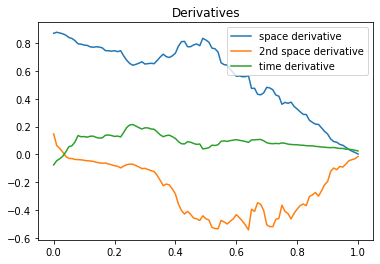

2511th Epoch:
traing loss is 9.157780732493848e-05, test loss is 5.168615825823508e-05, and learning rate is 6.405027670552954e-05, elapsed is 5.132206678390503.
 
2521th Epoch:
traing loss is 6.055086851119995e-05, test loss is 5.1290244300616905e-05, and learning rate is 6.405027670552954e-05, elapsed is 4.421867370605469.
 
2531th Epoch:
traing loss is 3.596578608267009e-05, test loss is 4.8749716370366514e-05, and learning rate is 6.405027670552954e-05, elapsed is 4.439593553543091.
 
2541th Epoch:
traing loss is 4.858241300098598e-05, test loss is 4.9564252549316734e-05, and learning rate is 6.405027670552954e-05, elapsed is 4.406719207763672.
 
2551th Epoch:
traing loss is 3.852824374916963e-05, test loss is 5.152880112291314e-05, and learning rate is 6.276927888393402e-05, elapsed is 4.418585538864136.
 
2561th Epoch:
traing loss is 5.620495358016342e-05, test loss is 4.812743645743467e-05, and learning rate is 6.276927888393402e-05, elapsed is 4.449704647064209.
 
2571th Epoch:

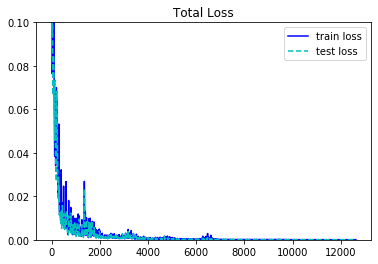

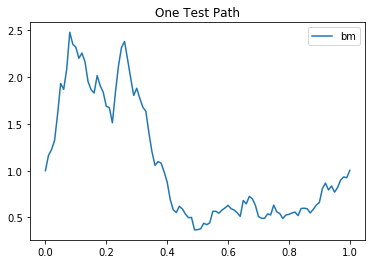

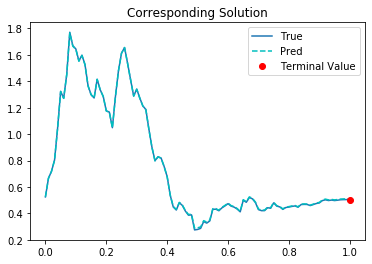

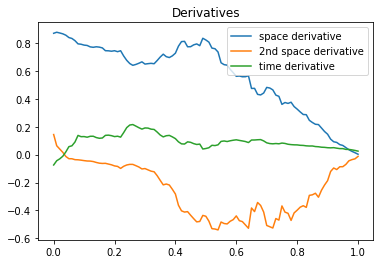

2611th Epoch:
traing loss is 9.32854600250721e-05, test loss is 5.0984901463380083e-05, and learning rate is 6.151388515718281e-05, elapsed is 5.1942901611328125.
 
2621th Epoch:
traing loss is 6.241371011128649e-05, test loss is 5.1325681852176785e-05, and learning rate is 6.151388515718281e-05, elapsed is 4.530981063842773.
 
2631th Epoch:
traing loss is 3.6194873246131465e-05, test loss is 4.906216781819239e-05, and learning rate is 6.151388515718281e-05, elapsed is 4.478468656539917.
 
2641th Epoch:
traing loss is 4.4016829633619636e-05, test loss is 4.899797204416245e-05, and learning rate is 6.151388515718281e-05, elapsed is 4.442162752151489.
 
2651th Epoch:
traing loss is 3.635706889326684e-05, test loss is 5.0092283345293254e-05, and learning rate is 6.028361167409457e-05, elapsed is 4.424588918685913.
 
2661th Epoch:
traing loss is 5.920883268117905e-05, test loss is 4.858925603912212e-05, and learning rate is 6.028361167409457e-05, elapsed is 4.449198007583618.
 
2671th Epoc

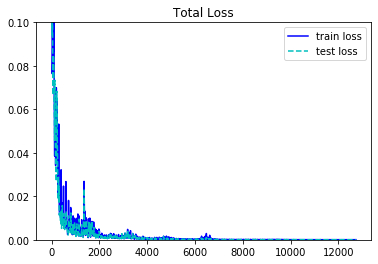

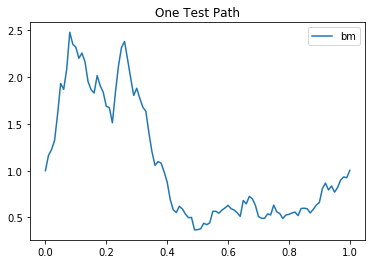

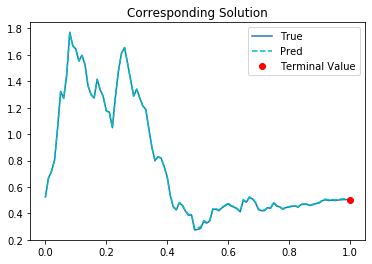

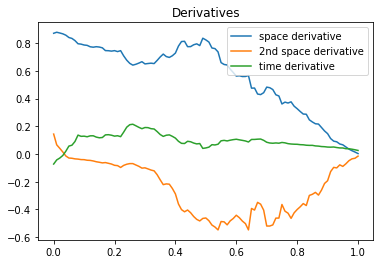

2711th Epoch:
traing loss is 8.990993956103921e-05, test loss is 5.0115548219764605e-05, and learning rate is 5.907794911763631e-05, elapsed is 5.147543430328369.
 
2721th Epoch:
traing loss is 5.960364796919748e-05, test loss is 5.009373489883728e-05, and learning rate is 5.907794911763631e-05, elapsed is 4.429163455963135.
 
2731th Epoch:
traing loss is 3.547037340467796e-05, test loss is 4.848729804507457e-05, and learning rate is 5.907794911763631e-05, elapsed is 4.540990591049194.
 
2741th Epoch:
traing loss is 4.80313683510758e-05, test loss is 4.969740257365629e-05, and learning rate is 5.907794911763631e-05, elapsed is 4.438547134399414.
 
2751th Epoch:
traing loss is 3.807486064033583e-05, test loss is 5.1064005674561486e-05, and learning rate is 5.789638453279622e-05, elapsed is 4.552427768707275.
 
2761th Epoch:
traing loss is 5.576199691859074e-05, test loss is 4.8319856432499364e-05, and learning rate is 5.789638453279622e-05, elapsed is 4.424384593963623.
 
2771th Epoch:


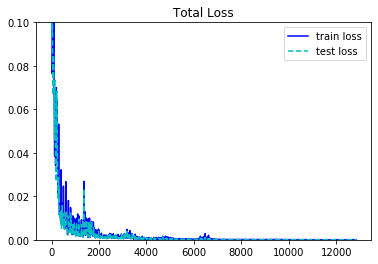

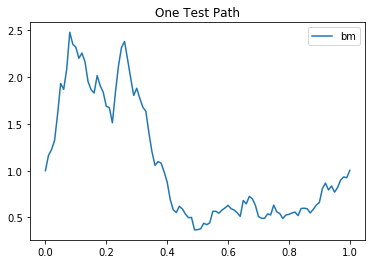

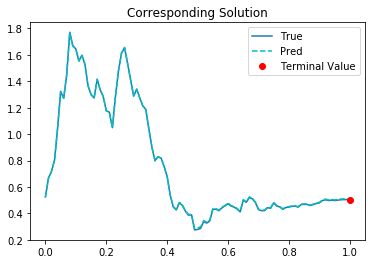

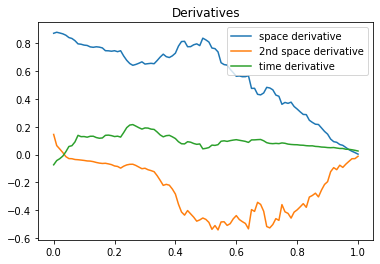

2811th Epoch:
traing loss is 9.186220995616168e-05, test loss is 4.991126115783118e-05, and learning rate is 5.6738455896265805e-05, elapsed is 5.225837469100952.
 
2821th Epoch:
traing loss is 6.188578117871657e-05, test loss is 5.051626430940814e-05, and learning rate is 5.6738455896265805e-05, elapsed is 4.432475328445435.
 
2831th Epoch:
traing loss is 3.6023047869093716e-05, test loss is 4.899195482721552e-05, and learning rate is 5.6738455896265805e-05, elapsed is 4.386310577392578.
 
2841th Epoch:
traing loss is 4.3483083572937176e-05, test loss is 4.871114288107492e-05, and learning rate is 5.6738455896265805e-05, elapsed is 4.403493881225586.
 
2851th Epoch:
traing loss is 3.5816061426885426e-05, test loss is 4.961791273672134e-05, and learning rate is 5.5603690270800143e-05, elapsed is 4.425873279571533.
 
2861th Epoch:
traing loss is 5.7726978411665186e-05, test loss is 4.773011096403934e-05, and learning rate is 5.5603690270800143e-05, elapsed is 4.395070314407349.
 
2871th

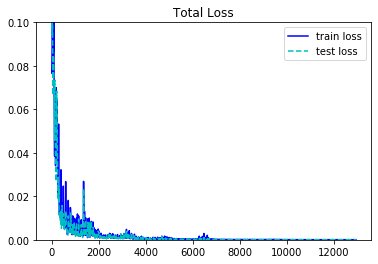

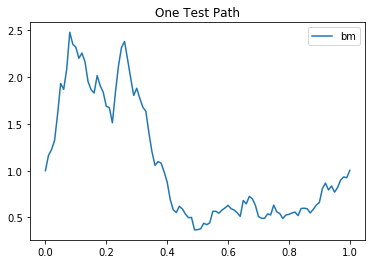

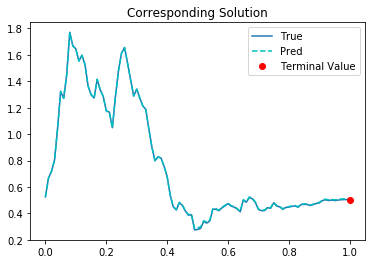

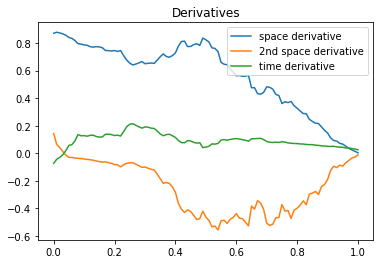

2911th Epoch:
traing loss is 8.778485789662227e-05, test loss is 4.9838035920402035e-05, and learning rate is 5.449161835713312e-05, elapsed is 5.184551000595093.
 
2921th Epoch:
traing loss is 5.931731720920652e-05, test loss is 4.977561911800876e-05, and learning rate is 5.449161835713312e-05, elapsed is 4.412863731384277.
 
2931th Epoch:
traing loss is 3.547400774550624e-05, test loss is 4.851284757023677e-05, and learning rate is 5.449161835713312e-05, elapsed is 4.388877868652344.
 
2941th Epoch:
traing loss is 4.738355346489698e-05, test loss is 4.964286563335918e-05, and learning rate is 5.449161835713312e-05, elapsed is 4.423803806304932.
 
2951th Epoch:
traing loss is 3.7582984077744186e-05, test loss is 5.0631806516321376e-05, and learning rate is 5.3401789045892656e-05, elapsed is 4.392279386520386.
 
2961th Epoch:
traing loss is 5.480151594383642e-05, test loss is 4.768343933392316e-05, and learning rate is 5.3401789045892656e-05, elapsed is 4.467297554016113.
 
2971th Epoc

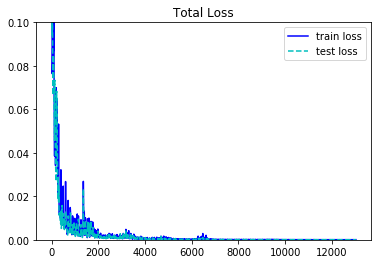

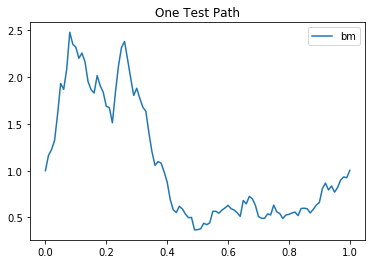

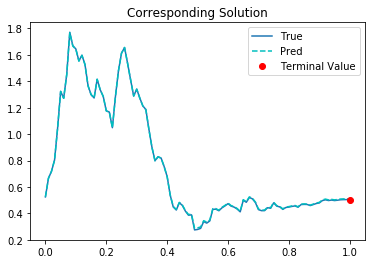

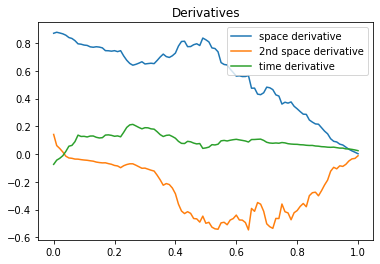

3011th Epoch:
traing loss is 9.028050408232957e-05, test loss is 4.9375576054444537e-05, and learning rate is 5.233375122770667e-05, elapsed is 5.1479668617248535.
 
3021th Epoch:
traing loss is 6.198333721840754e-05, test loss is 5.0529208238003775e-05, and learning rate is 5.233375122770667e-05, elapsed is 4.439275741577148.
 
3031th Epoch:
traing loss is 3.595362795749679e-05, test loss is 4.893439472652972e-05, and learning rate is 5.233375122770667e-05, elapsed is 4.3801350593566895.
 
3041th Epoch:
traing loss is 4.268966586096212e-05, test loss is 4.833040293306112e-05, and learning rate is 5.233375122770667e-05, elapsed is 4.429169654846191.
 
3051th Epoch:
traing loss is 3.504131382214837e-05, test loss is 4.8556412366451696e-05, and learning rate is 5.128707562107593e-05, elapsed is 4.396590948104858.
 
3061th Epoch:
traing loss is 5.701927511836402e-05, test loss is 4.72889696538914e-05, and learning rate is 5.128707562107593e-05, elapsed is 4.387975454330444.
 
3071th Epoch

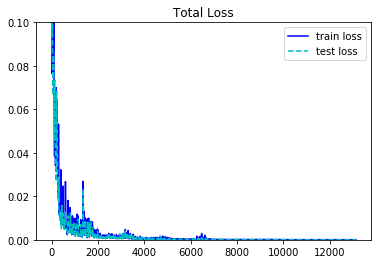

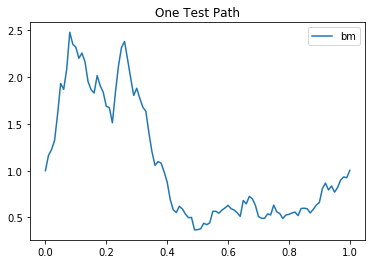

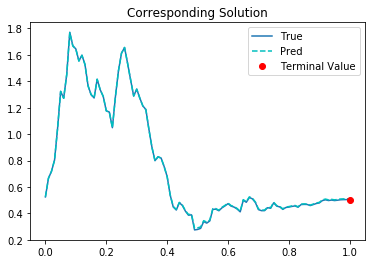

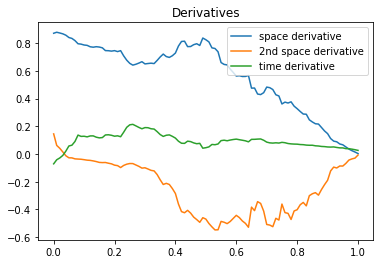

3111th Epoch:
traing loss is 8.71576921781525e-05, test loss is 4.987398278899491e-05, and learning rate is 5.026133294450119e-05, elapsed is 5.185376167297363.
 
3121th Epoch:
traing loss is 6.0712456615874544e-05, test loss is 5.037162554799579e-05, and learning rate is 5.026133294450119e-05, elapsed is 4.403770446777344.
 
3131th Epoch:
traing loss is 3.529198875185102e-05, test loss is 4.822407936444506e-05, and learning rate is 5.026133294450119e-05, elapsed is 4.460350751876831.
 
3141th Epoch:
traing loss is 4.603213528753258e-05, test loss is 4.8592315579298884e-05, and learning rate is 5.026133294450119e-05, elapsed is 4.435446262359619.
 
3151th Epoch:
traing loss is 3.5621120332507417e-05, test loss is 4.808730591321364e-05, and learning rate is 4.925610846839845e-05, elapsed is 4.4424638748168945.
 
3161th Epoch:
traing loss is 5.453102130559273e-05, test loss is 4.70719751319848e-05, and learning rate is 4.925610846839845e-05, elapsed is 4.468475341796875.
 
3171th Epoch:


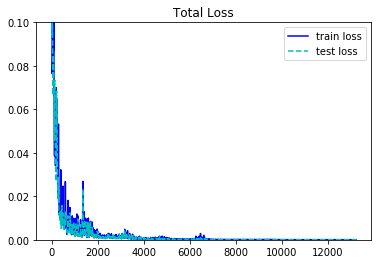

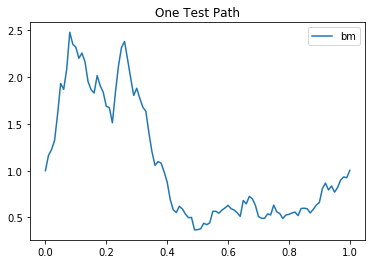

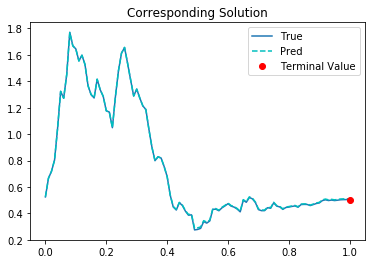

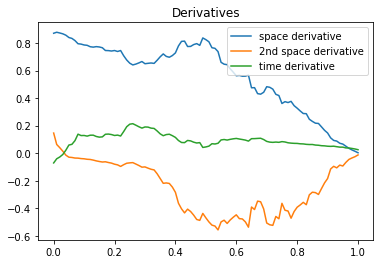

3211th Epoch:
traing loss is 8.99169608601369e-05, test loss is 5.0235670641995966e-05, and learning rate is 4.82709874631837e-05, elapsed is 5.193097352981567.
 
3221th Epoch:
traing loss is 6.238226342247799e-05, test loss is 5.124070230522193e-05, and learning rate is 4.82709874631837e-05, elapsed is 4.416949272155762.
 
3231th Epoch:
traing loss is 3.562868732842617e-05, test loss is 4.839501343667507e-05, and learning rate is 4.82709874631837e-05, elapsed is 4.452065467834473.
 
3241th Epoch:
traing loss is 4.22159064328298e-05, test loss is 4.7685596655355766e-05, and learning rate is 4.82709874631837e-05, elapsed is 4.497323513031006.
 
3251th Epoch:
traing loss is 3.417054904275574e-05, test loss is 4.746926060761325e-05, and learning rate is 4.730556975118816e-05, elapsed is 4.442641258239746.
 
3261th Epoch:
traing loss is 5.6056374887702987e-05, test loss is 4.673569856095128e-05, and learning rate is 4.730556975118816e-05, elapsed is 4.486103057861328.
 
3271th Epoch:
train

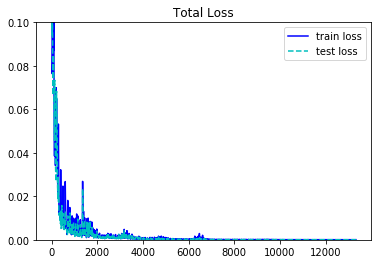

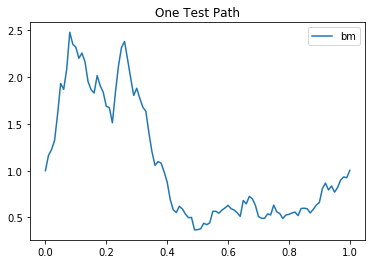

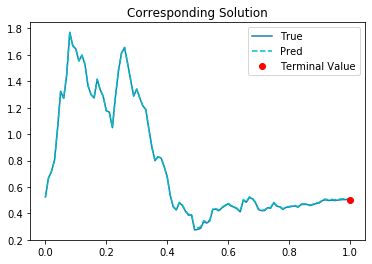

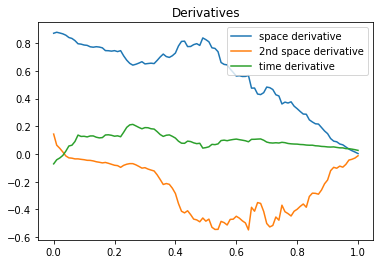

3311th Epoch:
traing loss is 8.802608499536291e-05, test loss is 5.079625771031715e-05, and learning rate is 4.635945879272185e-05, elapsed is 5.219542980194092.
 
3321th Epoch:
traing loss is 6.041522283339873e-05, test loss is 5.027771112509072e-05, and learning rate is 4.635945879272185e-05, elapsed is 4.496380567550659.
 
3331th Epoch:
traing loss is 3.485685010673478e-05, test loss is 4.7166999138426036e-05, and learning rate is 4.635945879272185e-05, elapsed is 4.405999660491943.
 
3341th Epoch:
traing loss is 4.4458825868787244e-05, test loss is 4.7255340177798644e-05, and learning rate is 4.635945879272185e-05, elapsed is 4.435257434844971.
 
3351th Epoch:
traing loss is 3.4516426239861175e-05, test loss is 4.676027310779318e-05, and learning rate is 4.5432276237988845e-05, elapsed is 4.458625316619873.
 
3361th Epoch:
traing loss is 5.363889431464486e-05, test loss is 4.622280539479107e-05, and learning rate is 4.5432276237988845e-05, elapsed is 4.4343345165252686.
 
3371th Ep

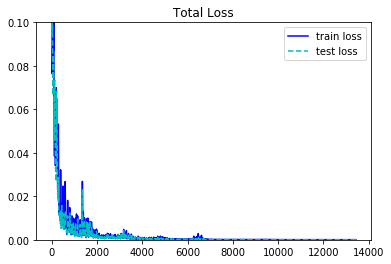

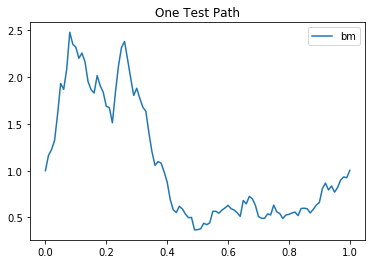

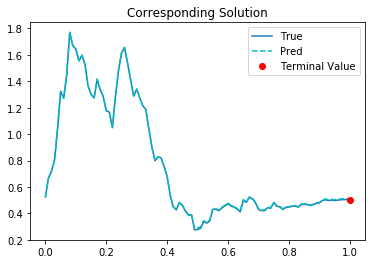

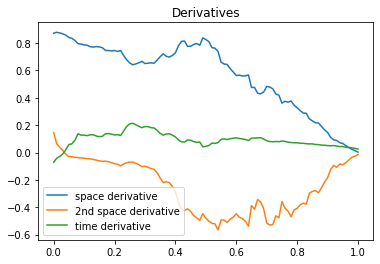

3411th Epoch:
traing loss is 8.943913417169824e-05, test loss is 5.0938964704982936e-05, and learning rate is 4.452362554729916e-05, elapsed is 5.164912462234497.
 
3421th Epoch:
traing loss is 6.136477895779535e-05, test loss is 5.024563506594859e-05, and learning rate is 4.452362554729916e-05, elapsed is 4.415992736816406.
 
3431th Epoch:
traing loss is 3.489850860205479e-05, test loss is 4.7041135985637084e-05, and learning rate is 4.452362554729916e-05, elapsed is 4.431339979171753.
 
3441th Epoch:
traing loss is 4.1977298678830266e-05, test loss is 4.73922336823307e-05, and learning rate is 4.452362554729916e-05, elapsed is 4.379347801208496.
 
3451th Epoch:
traing loss is 3.383490548003465e-05, test loss is 4.653975338442251e-05, and learning rate is 4.3633153836708516e-05, elapsed is 4.426590442657471.
 
3461th Epoch:
traing loss is 5.433686965261586e-05, test loss is 4.6007789933355525e-05, and learning rate is 4.3633153836708516e-05, elapsed is 4.395045042037964.
 
3471th Epoc

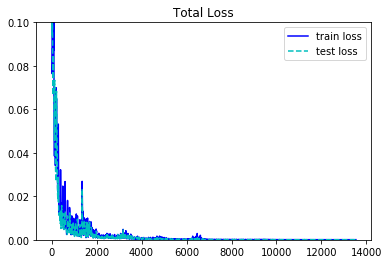

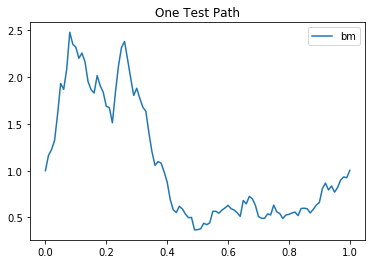

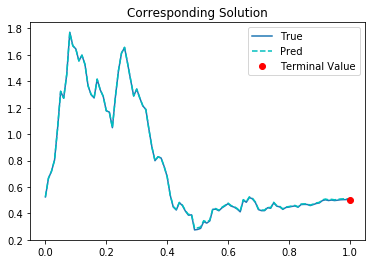

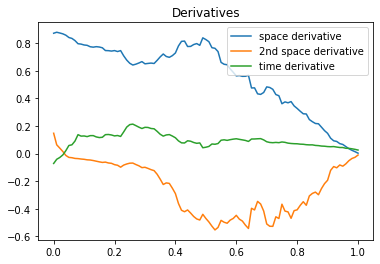

3511th Epoch:
traing loss is 8.694357529748231e-05, test loss is 5.1361206715228036e-05, and learning rate is 4.276049367035739e-05, elapsed is 5.164484024047852.
 
3521th Epoch:
traing loss is 5.94432967773173e-05, test loss is 4.934996832162142e-05, and learning rate is 4.276049367035739e-05, elapsed is 4.398425817489624.
 
3531th Epoch:
traing loss is 3.468330032774247e-05, test loss is 4.649349648389034e-05, and learning rate is 4.276049367035739e-05, elapsed is 4.34813117980957.
 
3541th Epoch:
traing loss is 4.388421803014353e-05, test loss is 4.6711298637092113e-05, and learning rate is 4.276049367035739e-05, elapsed is 4.4017863273620605.
 
3551th Epoch:
traing loss is 3.417197513044812e-05, test loss is 4.640297993319109e-05, and learning rate is 4.190528852632269e-05, elapsed is 4.3835225105285645.
 
3561th Epoch:
traing loss is 5.3262076107785106e-05, test loss is 4.5699081965722144e-05, and learning rate is 4.190528852632269e-05, elapsed is 4.369712591171265.
 
3571th Epoch

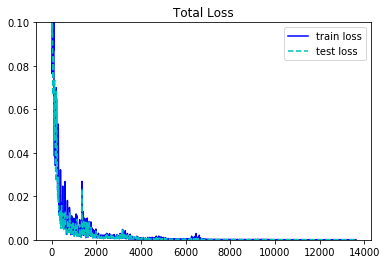

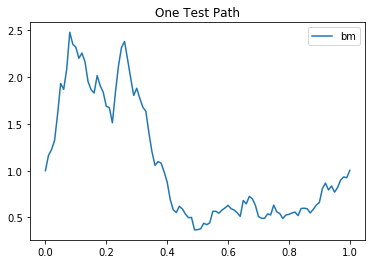

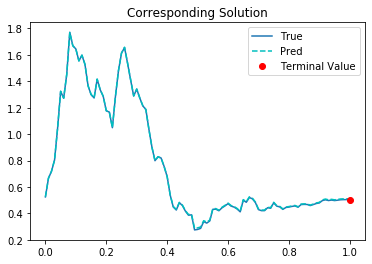

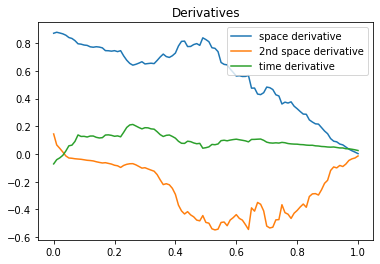

3611th Epoch:
traing loss is 8.984971645986661e-05, test loss is 5.158648855285719e-05, and learning rate is 4.1067181882681325e-05, elapsed is 6.016761779785156.
 
3621th Epoch:
traing loss is 5.9634865465341136e-05, test loss is 4.929031274514273e-05, and learning rate is 4.1067181882681325e-05, elapsed is 4.582682132720947.
 
3631th Epoch:
traing loss is 3.479908264125697e-05, test loss is 4.6717701479792595e-05, and learning rate is 4.1067181882681325e-05, elapsed is 4.612168788909912.
 
3641th Epoch:
traing loss is 4.181179974693805e-05, test loss is 4.689468914875761e-05, and learning rate is 4.1067181882681325e-05, elapsed is 4.544906854629517.
 
3651th Epoch:
traing loss is 3.407477925065905e-05, test loss is 4.696655014413409e-05, and learning rate is 4.0245839045383036e-05, elapsed is 4.460994720458984.
 
3661th Epoch:
traing loss is 5.353591768653132e-05, test loss is 4.55848676210735e-05, and learning rate is 4.0245839045383036e-05, elapsed is 4.449575424194336.
 
3671th Ep

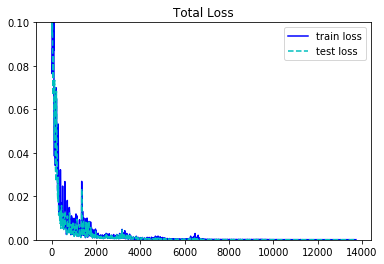

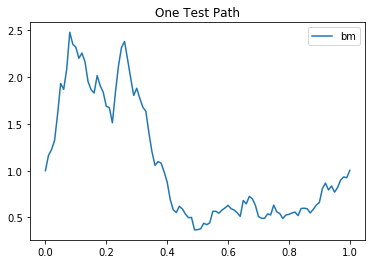

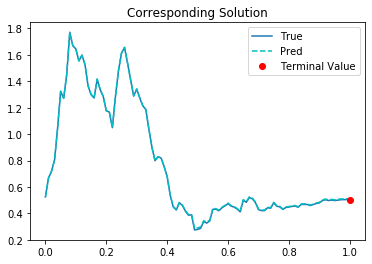

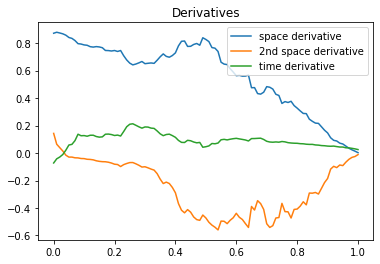

3711th Epoch:
traing loss is 8.807982521830127e-05, test loss is 5.177676575840451e-05, and learning rate is 3.944091804441996e-05, elapsed is 5.150430679321289.
 
3721th Epoch:
traing loss is 5.854268601979129e-05, test loss is 4.851646735914983e-05, and learning rate is 3.944091804441996e-05, elapsed is 4.4473021030426025.
 
3731th Epoch:
traing loss is 3.481072417343967e-05, test loss is 4.655708107748069e-05, and learning rate is 3.944091804441996e-05, elapsed is 4.405638217926025.
 
3741th Epoch:
traing loss is 4.288462150725536e-05, test loss is 4.629609247785993e-05, and learning rate is 3.944091804441996e-05, elapsed is 4.48252272605896.
 
3751th Epoch:
traing loss is 3.419080894673243e-05, test loss is 4.6720739192096516e-05, and learning rate is 3.865210237563588e-05, elapsed is 4.4564971923828125.
 
3761th Epoch:
traing loss is 5.3139174269745126e-05, test loss is 4.562840695143677e-05, and learning rate is 3.865210237563588e-05, elapsed is 4.466827154159546.
 
3771th Epoch:

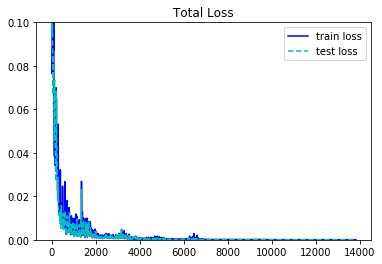

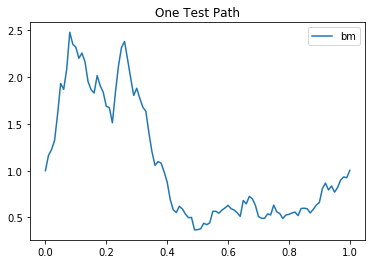

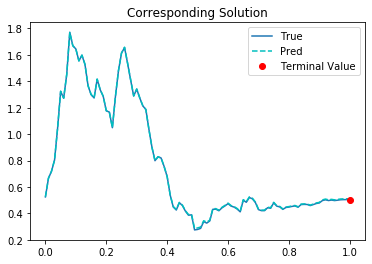

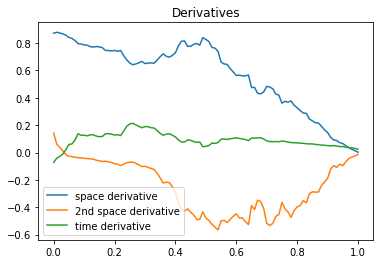

3811th Epoch:
traing loss is 9.02496394701302e-05, test loss is 5.270675683277659e-05, and learning rate is 3.7879060982959345e-05, elapsed is 5.265313625335693.
 
3821th Epoch:
traing loss is 5.8139328757533804e-05, test loss is 4.8146619519684464e-05, and learning rate is 3.7879060982959345e-05, elapsed is 4.468214273452759.
 
3831th Epoch:
traing loss is 3.5118097002850845e-05, test loss is 4.6605146053479984e-05, and learning rate is 3.7879060982959345e-05, elapsed is 4.450378894805908.
 
3841th Epoch:
traing loss is 4.140925739193335e-05, test loss is 4.6241944801295176e-05, and learning rate is 3.7879060982959345e-05, elapsed is 4.429964780807495.
 
3851th Epoch:
traing loss is 3.388923505553976e-05, test loss is 4.7003155486891046e-05, and learning rate is 3.712148100021295e-05, elapsed is 4.452941417694092.
 
3861th Epoch:
traing loss is 5.358580165193416e-05, test loss is 4.5530796342063695e-05, and learning rate is 3.712148100021295e-05, elapsed is 4.454671621322632.
 
3871th

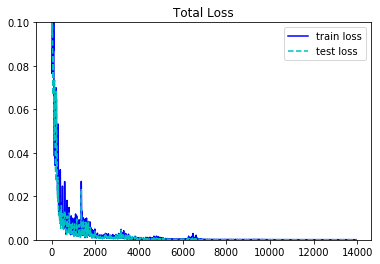

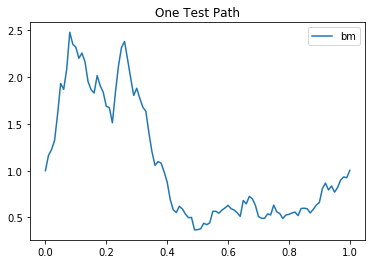

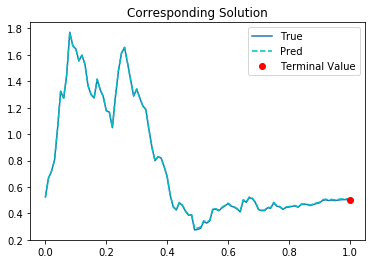

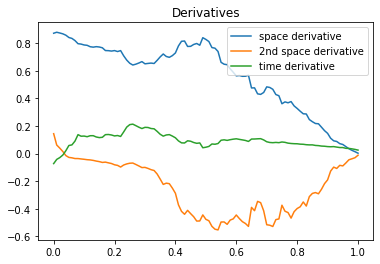

3911th Epoch:
traing loss is 8.89707007445395e-05, test loss is 5.334575689630583e-05, and learning rate is 3.637904956121929e-05, elapsed is 5.158568620681763.
 
3921th Epoch:
traing loss is 5.721948036807589e-05, test loss is 4.8005000280682e-05, and learning rate is 3.637904956121929e-05, elapsed is 4.386871337890625.
 
3931th Epoch:
traing loss is 3.467837814241648e-05, test loss is 4.629011164070107e-05, and learning rate is 3.637904956121929e-05, elapsed is 4.4476282596588135.
 
3941th Epoch:
traing loss is 4.232833089190535e-05, test loss is 4.608551535056904e-05, and learning rate is 3.637904956121929e-05, elapsed is 4.435798406600952.
 
3951th Epoch:
traing loss is 3.408431075513363e-05, test loss is 4.624198118108325e-05, and learning rate is 3.565147562767379e-05, elapsed is 4.435148000717163.
 
3961th Epoch:
traing loss is 5.322147990227677e-05, test loss is 4.550949597614817e-05, and learning rate is 3.565147562767379e-05, elapsed is 4.405657768249512.
 
3971th Epoch:
trai

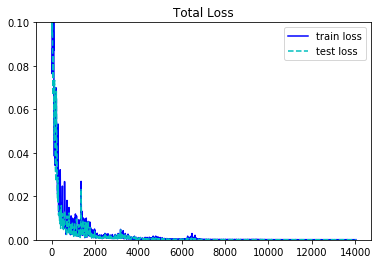

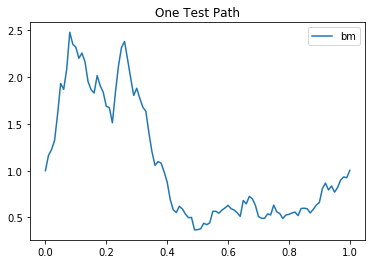

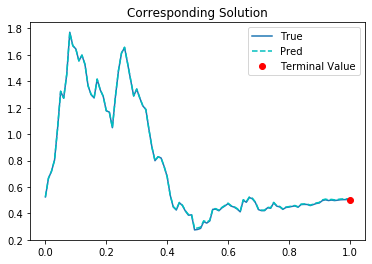

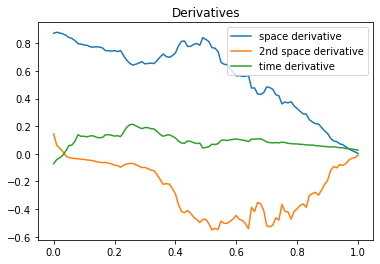

4011th Epoch:
traing loss is 9.0073786850553e-05, test loss is 5.3984822443453595e-05, and learning rate is 3.4938442695420235e-05, elapsed is 5.3417809009552.
 
4021th Epoch:
traing loss is 5.701995542040095e-05, test loss is 4.769134466187097e-05, and learning rate is 3.4938442695420235e-05, elapsed is 4.568864107131958.
 
4031th Epoch:
traing loss is 3.407117765164003e-05, test loss is 4.56827983725816e-05, and learning rate is 3.4938442695420235e-05, elapsed is 4.423943996429443.
 
4041th Epoch:
traing loss is 4.173625347902998e-05, test loss is 4.612859265762381e-05, and learning rate is 3.4938442695420235e-05, elapsed is 4.4680609703063965.
 
4051th Epoch:
traing loss is 3.359786205692217e-05, test loss is 4.6032833779463544e-05, and learning rate is 3.423967427806929e-05, elapsed is 4.4707090854644775.
 
4061th Epoch:
traing loss is 5.3674011724069715e-05, test loss is 4.566987627185881e-05, and learning rate is 3.423967427806929e-05, elapsed is 4.475528001785278.
 
4071th Epoch

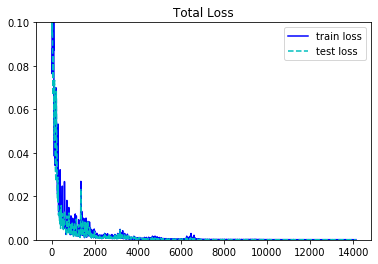

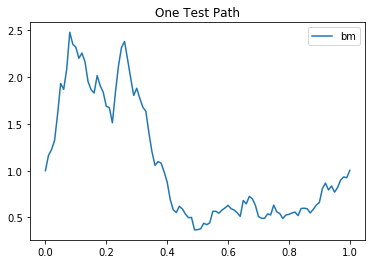

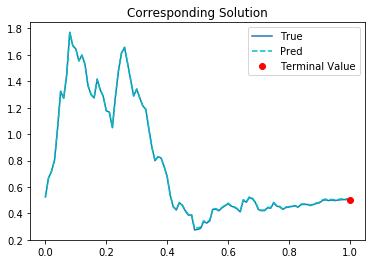

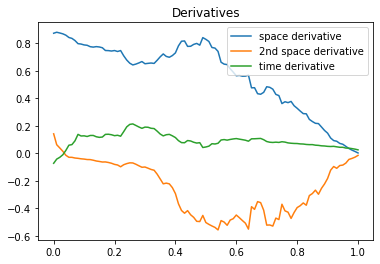

4111th Epoch:
traing loss is 8.960919512901455e-05, test loss is 5.395278276409954e-05, and learning rate is 3.355487933731638e-05, elapsed is 5.406120300292969.
 
4121th Epoch:
traing loss is 5.66379058000166e-05, test loss is 4.7718196583446115e-05, and learning rate is 3.355487933731638e-05, elapsed is 4.51205849647522.
 
4131th Epoch:
traing loss is 3.3571734093129635e-05, test loss is 4.529748548520729e-05, and learning rate is 3.355487933731638e-05, elapsed is 4.451043128967285.
 
4141th Epoch:
traing loss is 4.253110819263384e-05, test loss is 4.6024575567571446e-05, and learning rate is 3.355487933731638e-05, elapsed is 4.5641374588012695.
 
4151th Epoch:
traing loss is 3.3522472222102806e-05, test loss is 4.546435229713097e-05, and learning rate is 3.288378502475098e-05, elapsed is 4.557504892349243.
 
4161th Epoch:
traing loss is 5.3003066568635404e-05, test loss is 4.552106838673353e-05, and learning rate is 3.288378502475098e-05, elapsed is 4.523335218429565.
 
4171th Epoch

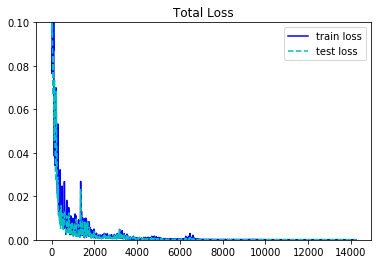

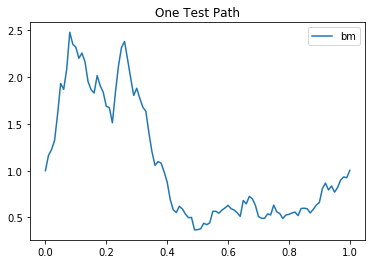

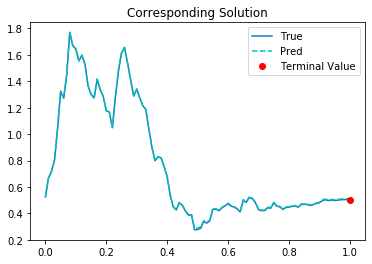

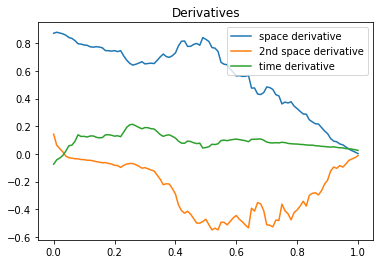

4211th Epoch:
traing loss is 8.912650082493201e-05, test loss is 5.3364787163445726e-05, and learning rate is 3.222611121600494e-05, elapsed is 5.307924270629883.
 
4221th Epoch:
traing loss is 5.5857271945569664e-05, test loss is 4.754691690322943e-05, and learning rate is 3.222611121600494e-05, elapsed is 4.478587627410889.
 
4231th Epoch:
traing loss is 3.317551454529166e-05, test loss is 4.497316331253387e-05, and learning rate is 3.222611121600494e-05, elapsed is 4.49401068687439.
 
4241th Epoch:
traing loss is 4.193495988147333e-05, test loss is 4.58126341982279e-05, and learning rate is 3.222611121600494e-05, elapsed is 4.5991051197052.
 
4251th Epoch:
traing loss is 3.304558413219638e-05, test loss is 4.537982022156939e-05, and learning rate is 3.1581588700646535e-05, elapsed is 4.70028018951416.
 
4261th Epoch:
traing loss is 5.23632115800865e-05, test loss is 4.509193968260661e-05, and learning rate is 3.1581588700646535e-05, elapsed is 4.730633974075317.
 
4271th Epoch:
trai

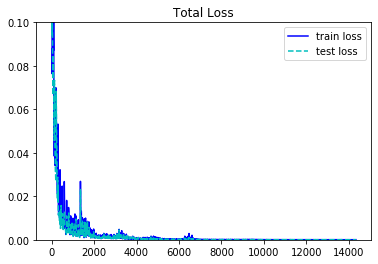

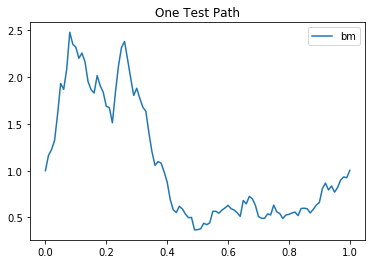

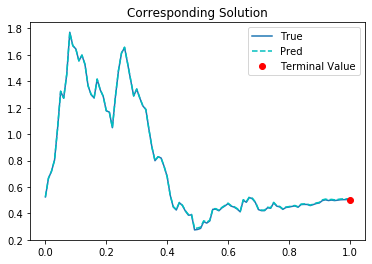

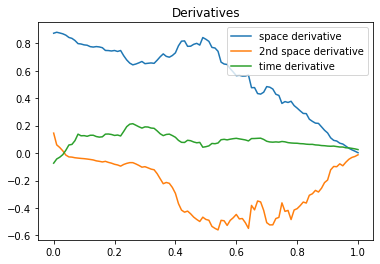

4311th Epoch:
traing loss is 8.72526434250176e-05, test loss is 5.245112697593868e-05, and learning rate is 3.094995554420166e-05, elapsed is 5.38139009475708.
 
4321th Epoch:
traing loss is 5.533844159799628e-05, test loss is 4.713070666184649e-05, and learning rate is 3.094995554420166e-05, elapsed is 4.62223482131958.
 
4331th Epoch:
traing loss is 3.3028969482984394e-05, test loss is 4.4777290895581245e-05, and learning rate is 3.094995554420166e-05, elapsed is 4.525014638900757.
 
4341th Epoch:
traing loss is 4.181607801001519e-05, test loss is 4.5498600229620934e-05, and learning rate is 3.094995554420166e-05, elapsed is 4.510896921157837.
 
4351th Epoch:
traing loss is 3.2916086638579145e-05, test loss is 4.484158125706017e-05, and learning rate is 3.0330958907143213e-05, elapsed is 4.472805976867676.
 
4361th Epoch:
traing loss is 5.186168345971964e-05, test loss is 4.477807306102477e-05, and learning rate is 3.0330958907143213e-05, elapsed is 4.54227089881897.
 
4371th Epoch:


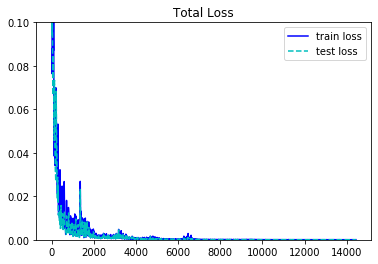

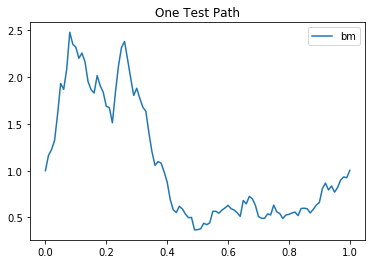

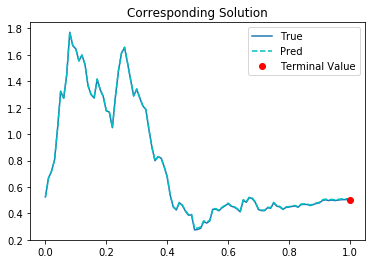

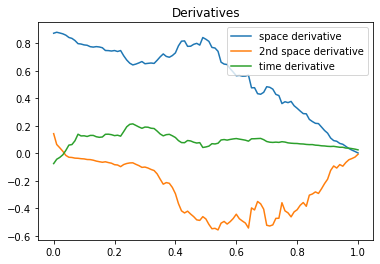

4411th Epoch:
traing loss is 8.730313857086003e-05, test loss is 5.1526465540518984e-05, and learning rate is 2.9724340492975898e-05, elapsed is 5.295843839645386.
 
4421th Epoch:
traing loss is 5.489647082868032e-05, test loss is 4.686095780925825e-05, and learning rate is 2.9724340492975898e-05, elapsed is 4.505649089813232.
 
4431th Epoch:
traing loss is 3.278403164586052e-05, test loss is 4.4642958528129384e-05, and learning rate is 2.9724340492975898e-05, elapsed is 4.477315902709961.
 
4441th Epoch:
traing loss is 4.133899710723199e-05, test loss is 4.532423918135464e-05, and learning rate is 2.9724340492975898e-05, elapsed is 4.4786741733551025.
 
4451th Epoch:
traing loss is 3.284337799414061e-05, test loss is 4.4781332690035924e-05, and learning rate is 2.912985291914083e-05, elapsed is 4.50931453704834.
 
4461th Epoch:
traing loss is 5.1885574066545814e-05, test loss is 4.442377030500211e-05, and learning rate is 2.912985291914083e-05, elapsed is 4.52019476890564.
 
4471th Ep

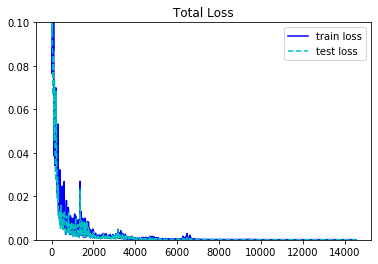

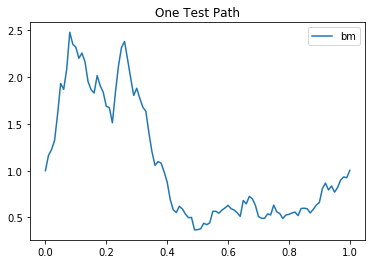

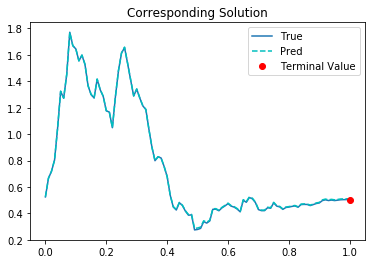

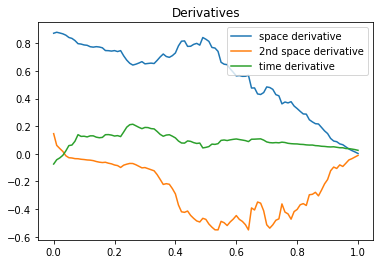

4511th Epoch:
traing loss is 8.662988693686202e-05, test loss is 5.068750033387914e-05, and learning rate is 2.854725426004734e-05, elapsed is 5.2977259159088135.
 
4521th Epoch:
traing loss is 5.451914694276638e-05, test loss is 4.6496217692038044e-05, and learning rate is 2.854725426004734e-05, elapsed is 4.449045419692993.
 
4531th Epoch:
traing loss is 3.2717282010708004e-05, test loss is 4.4820961193181574e-05, and learning rate is 2.854725426004734e-05, elapsed is 4.56729793548584.
 
4541th Epoch:
traing loss is 4.1425089875701815e-05, test loss is 4.521281516645104e-05, and learning rate is 2.854725426004734e-05, elapsed is 4.525994062423706.
 
4551th Epoch:
traing loss is 3.274807386333123e-05, test loss is 4.464756784727797e-05, and learning rate is 2.797631168505177e-05, elapsed is 4.505815744400024.
 
4561th Epoch:
traing loss is 5.176819104235619e-05, test loss is 4.4418931793188676e-05, and learning rate is 2.797631168505177e-05, elapsed is 4.4628448486328125.
 
4571th Epo

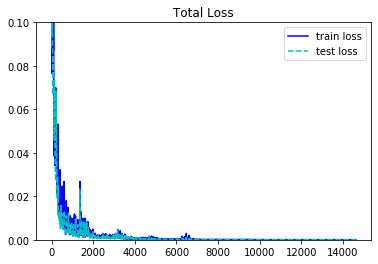

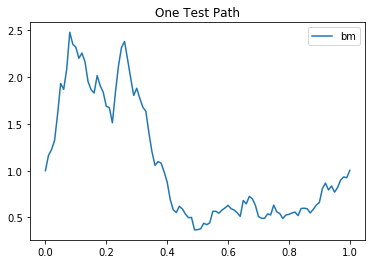

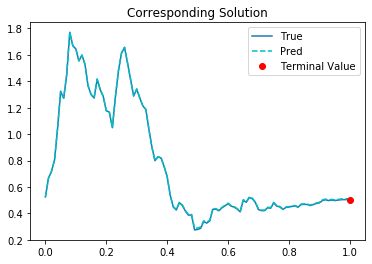

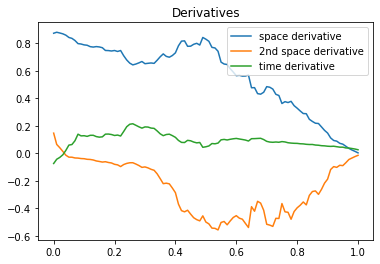

4611th Epoch:
traing loss is 8.655678539071232e-05, test loss is 5.006472201785073e-05, and learning rate is 2.7416785087552853e-05, elapsed is 5.303097248077393.
 
4621th Epoch:
traing loss is 5.4053896747063845e-05, test loss is 4.616667501977645e-05, and learning rate is 2.7416785087552853e-05, elapsed is 4.505221366882324.
 
4631th Epoch:
traing loss is 3.291753455414437e-05, test loss is 4.473420631256886e-05, and learning rate is 2.7416785087552853e-05, elapsed is 4.539305925369263.
 
4641th Epoch:
traing loss is 4.1266186599386856e-05, test loss is 4.490933861234225e-05, and learning rate is 2.7416785087552853e-05, elapsed is 4.593410968780518.
 
4651th Epoch:
traing loss is 3.248750726925209e-05, test loss is 4.462771175894886e-05, and learning rate is 2.6868450731853954e-05, elapsed is 4.555561542510986.
 
4661th Epoch:
traing loss is 5.148550553712994e-05, test loss is 4.435396840563044e-05, and learning rate is 2.6868450731853954e-05, elapsed is 4.572635173797607.
 
4671th E

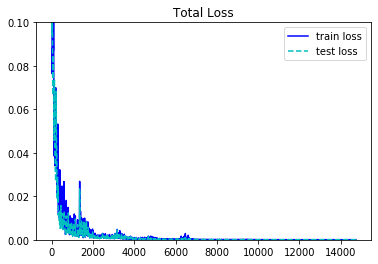

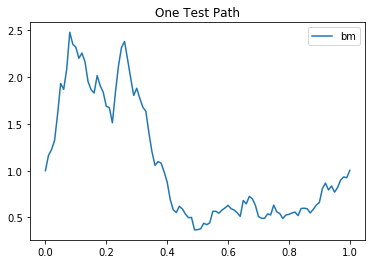

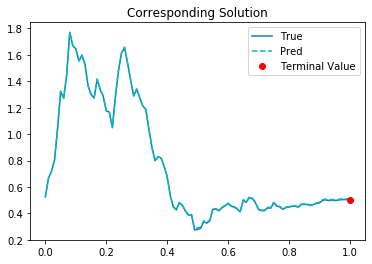

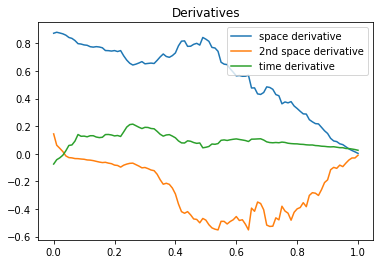

4711th Epoch:
traing loss is 8.601635636296123e-05, test loss is 4.983384133083746e-05, and learning rate is 2.6331084882258438e-05, elapsed is 5.308105945587158.
 
4721th Epoch:
traing loss is 5.3763324103783816e-05, test loss is 4.604563946486451e-05, and learning rate is 2.6331084882258438e-05, elapsed is 4.525753021240234.
 
4731th Epoch:
traing loss is 3.270291199441999e-05, test loss is 4.471569263841957e-05, and learning rate is 2.6331084882258438e-05, elapsed is 4.487612962722778.
 
4741th Epoch:
traing loss is 4.097838973393664e-05, test loss is 4.4646832975558937e-05, and learning rate is 2.6331084882258438e-05, elapsed is 4.456510543823242.
 
4751th Epoch:
traing loss is 3.2587398891337216e-05, test loss is 4.468236875254661e-05, and learning rate is 2.5804461984080262e-05, elapsed is 4.50564980506897.
 
4761th Epoch:
traing loss is 5.161032095202245e-05, test loss is 4.447512037586421e-05, and learning rate is 2.5804461984080262e-05, elapsed is 4.53427529335022.
 
4771th Ep

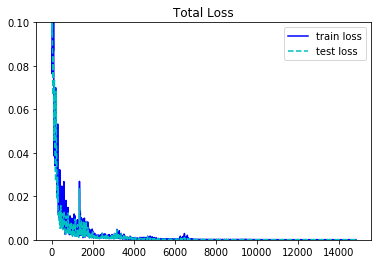

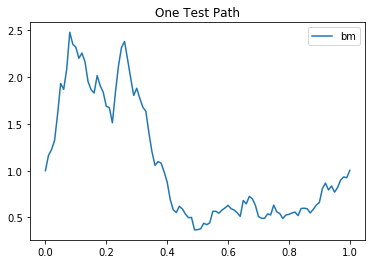

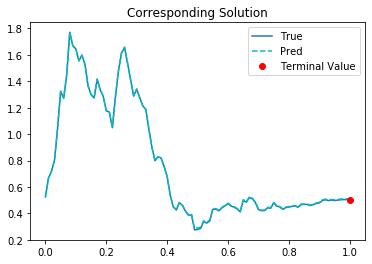

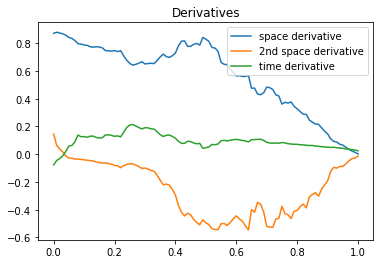

4811th Epoch:
traing loss is 8.585775503888726e-05, test loss is 4.971485759597272e-05, and learning rate is 2.5288371034548618e-05, elapsed is 5.299807071685791.
 
4821th Epoch:
traing loss is 5.334827073966153e-05, test loss is 4.560513480100781e-05, and learning rate is 2.5288371034548618e-05, elapsed is 4.5644049644470215.
 
4831th Epoch:
traing loss is 3.2756961445556954e-05, test loss is 4.46728226961568e-05, and learning rate is 2.5288371034548618e-05, elapsed is 4.501847982406616.
 
4841th Epoch:
traing loss is 4.069272108608857e-05, test loss is 4.479150447878055e-05, and learning rate is 2.5288371034548618e-05, elapsed is 4.481197357177734.
 
4851th Epoch:
traing loss is 3.2351828849641606e-05, test loss is 4.4557731598615646e-05, and learning rate is 2.4782606487860903e-05, elapsed is 4.5235595703125.
 
4861th Epoch:
traing loss is 5.155526741873473e-05, test loss is 4.446816092240624e-05, and learning rate is 2.4782606487860903e-05, elapsed is 4.548527956008911.
 
4871th Ep

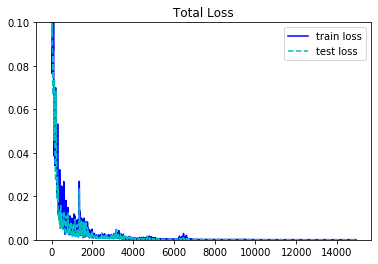

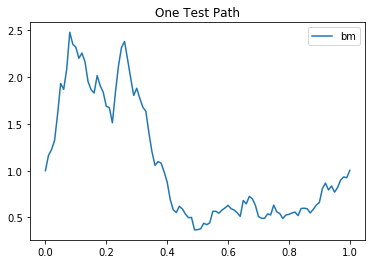

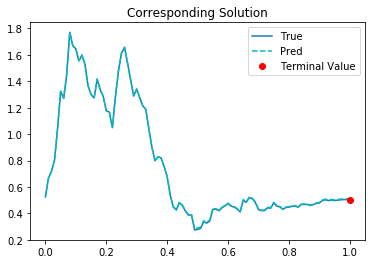

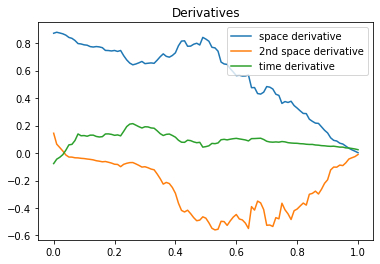

4911th Epoch:
traing loss is 8.465761493425816e-05, test loss is 4.948367495671846e-05, and learning rate is 2.4286951884278096e-05, elapsed is 5.3763391971588135.
 
4921th Epoch:
traing loss is 5.313904330250807e-05, test loss is 4.539902147371322e-05, and learning rate is 2.4286951884278096e-05, elapsed is 4.713003635406494.
 
4931th Epoch:
traing loss is 3.282873876742087e-05, test loss is 4.470819476409815e-05, and learning rate is 2.4286951884278096e-05, elapsed is 4.557750701904297.
 
4941th Epoch:
traing loss is 4.056010948261246e-05, test loss is 4.449399057193659e-05, and learning rate is 2.4286951884278096e-05, elapsed is 4.518983840942383.
 
4951th Epoch:
traing loss is 3.2321444450644776e-05, test loss is 4.44158649770543e-05, and learning rate is 2.3801216229912825e-05, elapsed is 4.510343074798584.
 
4961th Epoch:
traing loss is 5.13891973241698e-05, test loss is 4.429819091456011e-05, and learning rate is 2.3801216229912825e-05, elapsed is 4.513003349304199.
 
4971th Epo

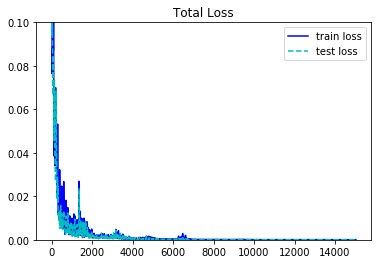

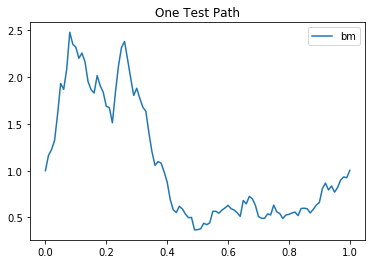

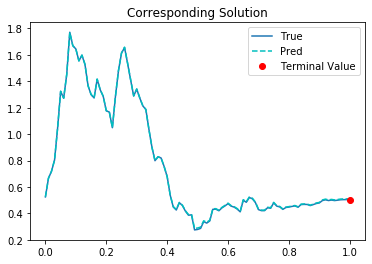

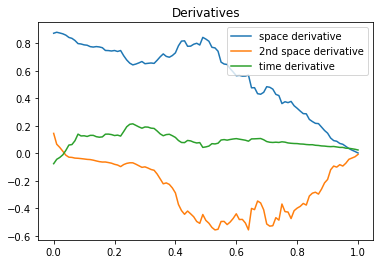

In [62]:
start_time = ttt.time()

for it in range(Epoch):
    seed = it % 100
    path_feed =  Create_paths(seed, M)
    feed_dict = {path: path_feed, time: time_feed}
    sess.run(train_op, feed_dict)

    if (it % 10 == 0): # every 10 epoch print and record
        elapsed = ttt.time() - start_time
        print("{}th Epoch:".format(it+1))
        loss_value = sess.run(loss, feed_dict)
        lr = sess.run(learning_rate)
        loss_test = sess.run(loss, pred_dict)
        print("traing loss is {}, test loss is {}, and learning rate is {}, elapsed is {}.".format(loss_value, loss_test, lr, elapsed))
        print(" ")

        train_loss_list.append(loss_value)
        test_loss_list.append(loss_test)        
        start_time = ttt.time()

    if (it % 100 == 0): # every 100 epoch, show picture

        solution_pred, time_derivative_pred, space_derivative_pred, space_2nd_derivative_pred = sess.run([solution, time_derivative, space_derivative, space_2nd_derivative], pred_dict)
        num_epoches = len(train_loss_list)
        x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)

        # plot train/test loss 
        plt.plot(x_axis_epoches, train_loss_list, 'b-', label = "train loss")
        plt.plot(x_axis_epoches, test_loss_list, 'c--', label = "test loss")
        plt.legend()
        plt.ylim([0, 0.1])
        plt.title("Total Loss")
        plt.show()
        
        # plot one example path
        plt.plot(t, path_test[1], label = "bm")
        plt.legend()
        plt.title("One Test Path")
        plt.show()
        
        # plot the true solution vs predicted solution
        plt.plot(t, true_solution(path_test[1]), label = "True")
        plt.plot(t, solution_pred[1], 'c--', label = "Pred")
        plt.plot(T, terminal_condition(path_test[1]), "ro", label = "Terminal Value")
        plt.legend()
        plt.title("Corresponding Solution")
        plt.show()
        
        # plot the time and space derivatives.
        plt.plot(np.linspace(0,T, steps+1), space_derivative_pred[1], label = "space derivative")
        plt.plot(np.linspace(0,T, steps+1), space_2nd_derivative_pred[1], label = "2nd space derivative")
        plt.plot(np.linspace(0,T, steps+1), time_derivative_pred[1], label = "time derivative")
        plt.legend()
        plt.title("Derivatives")
        plt.show()
        

## Evaluation

In [0]:
tf.gfile.MkDir("pics") # create new folder called pics

In [0]:
np.save('asian_train_loss_list.npy', train_loss_list)
np.save('asian_test_loss_list.npy', test_loss_list)
np.save('asian_solution_pred.npy', solution_pred)
np.save('asian_space_derivative_pred.npy', space_derivative_pred)
np.save('asian_space_2nd_derivative_pred.npy', space_derivative_pred)
np.save('asian_time_derivative_pred.npy', time_derivative_pred)

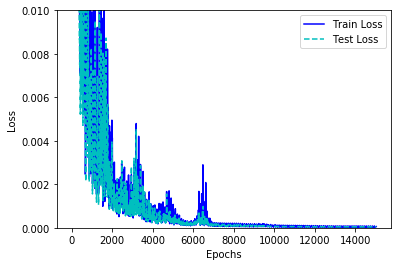

In [64]:
num_epoches = len(train_loss_list)
x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)
plt.plot(x_axis_epoches, train_loss_list, 'b-', label = "Train Loss")
plt.plot(x_axis_epoches, test_loss_list, 'c--', label = "Test Loss")
plt.legend()
plt.ylim([0, 0.01])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("./pics/geo_asian_loss.pdf")
plt.show()

In [0]:
solution_pred, time_derivative_pred, space_derivative_pred = sess.run([solution, time_derivative, space_derivative], pred_dict)

In [66]:
print(train_loss_list[-5:])
print(test_loss_list[-5:])

[5.1389197e-05, 3.5726593e-05, 5.001965e-05, 4.8587677e-05, 5.6292116e-05]
[4.429819e-05, 4.5140925e-05, 4.5509547e-05, 4.5945337e-05, 4.4432076e-05]


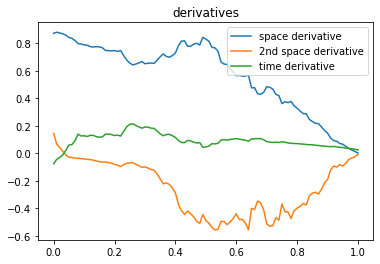

In [67]:
# plot derivatives
plt.plot(t, space_derivative_pred[1], label = "space derivative")
plt.plot(t, space_2nd_derivative_pred[1], label = "2nd space derivative")
plt.plot(t, time_derivative_pred[1], label = "time derivative")
plt.legend()
plt.title("derivatives")
plt.show()

Text(0.5, 1.0, '16 samples of GBMs')

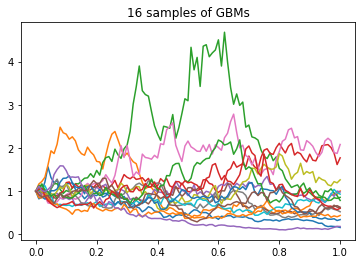

In [68]:
# 16 test paths
for i in range(16):
    plt.plot(t, path_test[i])
plt.title("16 samples of GBMs")

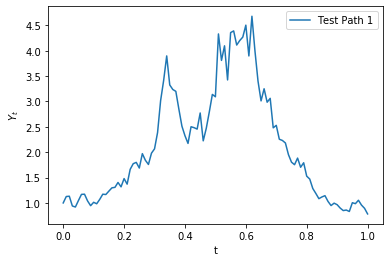

In [69]:
# A sample test path
plt.plot(t, path_test[2], label = "Test Path 1")
plt.xlabel("t")
plt.ylabel(r"$Y_t$")
plt.legend()
plt.savefig("./pics/geo_asian_test1.pdf")


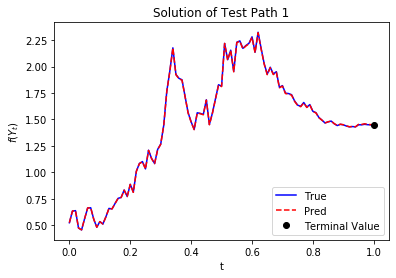

In [70]:
# comparison of true vs predicted solution for the above GBM path
plt.plot(t, true_solution(path_test[2]), "b", label = "True")
plt.plot(t, solution_pred[2], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test[2]), "ko", label = "Terminal Value")

plt.title(r"Solution of Test Path 1")
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.legend()
plt.savefig("./pics/geo_asian_sol1.pdf")

## Test Another Path

In [0]:
path_test2 = np.tile(np.linspace(1,1e-6, steps+1), (M,1))**2
pred_dict2 = {path: path_test2, time: time_feed}

In [0]:
solution_2, space_derivative_2, time_derivative_2 = sess.run([solution, space_derivative, time_derivative], pred_dict2)

In [73]:
loss_2 = sess.run(loss, pred_dict2)
loss_2

0.00025044766

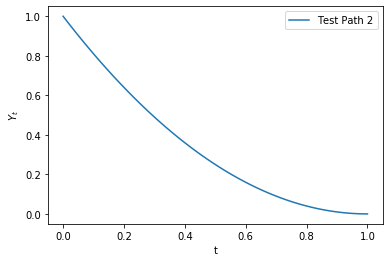

In [74]:
plt.plot(t, path_test2[1], label = "Test Path 2")
plt.legend()
# plt.title("Test Path 2")
plt.xlabel("t")
plt.ylabel(r"$Y_t$")

plt.savefig("./pics/geo_asian_test2.pdf")
plt.show()

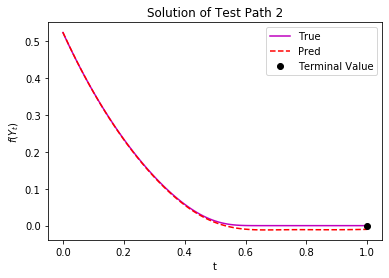

In [75]:
# comparison of true vs predicted solution of this path

plt.plot(t, true_solution(path_test2[1]), "m", label = "True")
plt.plot(t, solution_2[1], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test2[1]), "ko", label = "Terminal Value")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.title("Solution of Test Path 2")
plt.savefig("./pics/geo_asian_sol2.pdf")

In [0]:
## Test Another Path (Random Uniform)

In [0]:
np.random.seed(5)

path_test4 = np.tile(np.random.uniform(1, 3, steps+1), (M,1))
pred_dict4 = {path: path_test4, time: time_feed}

In [0]:
solution_4, space_derivative_4, time_derivative_4 = sess.run([solution, space_derivative, time_derivative], pred_dict4)

In [79]:
loss_4 = sess.run(loss, pred_dict4)
loss_4

0.0039016001

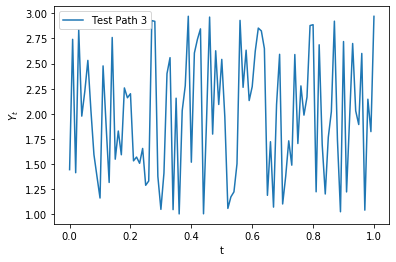

In [80]:
plt.plot(t, path_test4[1], label = "Test Path 3")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$Y_t$")


plt.savefig("./pics/geo_asian_test3.pdf")
plt.show()

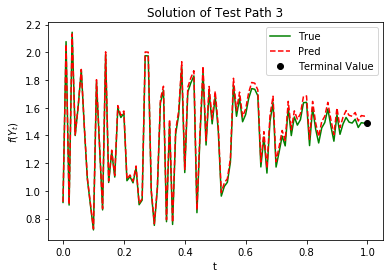

In [81]:
# comparison of true vs predicted solution of this path

plt.plot(t, true_solution(path_test4[1]),"g", label = "True")
plt.plot(t, solution_4[1], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test4[1]), "ko", label = "Terminal Value")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.title("Solution of Test Path 3")
plt.savefig("./pics/geo_asian_sol3.pdf")

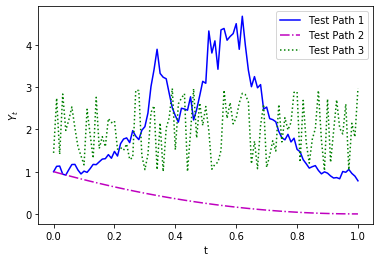

In [82]:
plt.plot(t, path_test[2], "b", label = "Test Path 1")
plt.plot(t, path_test2[1],"m-.", label = "Test Path 2")
plt.plot(t, path_test4[1], "g:", label = "Test Path 3")

plt.xlabel("t")
plt.ylabel("$Y_t$")
plt.legend()
plt.savefig("./pics/geo_asian_paths.pdf")